### 초기 경로 설정 (클래스 이용을 위함)

In [4]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [5]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet## 랜덤성을 배제한 환경 고정

## 랜덤성을 배제한 환경 고정

In [6]:
!nvidia-smi

Sun Oct  2 10:56:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 36%   29C    P8    24W / 350W |   2993MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:48:00.0 Off |                  N/A |
| 36%   

In [7]:
from models.ResUNet_plus3_CRF import CompNet

random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [9]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [11]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [12]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

# train_images = sorted(train_images)
# train_labels = sorted(train_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)
        
# valid_images = sorted(valid_images)
# valid_labels = sorted(valid_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)

My custom training-dataset has 489 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

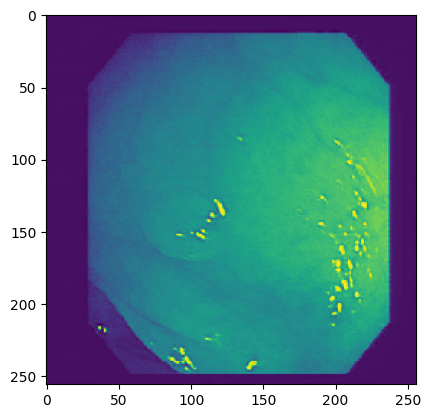

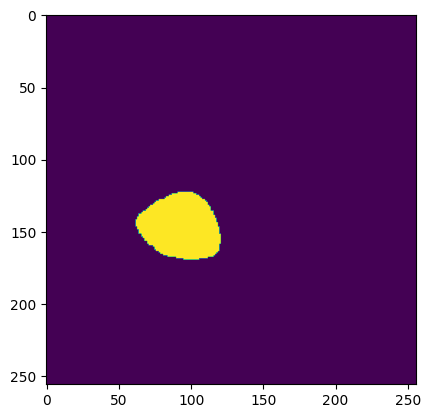

3픽셀의 평균값이라 색깔이 변경됨.


In [13]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [14]:
# Begin training
model = CompNet()
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [15]:
# Define variables for the training
epochs = 100
patience = 10
BATCH_SIZE = 16

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [16]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = IoUBCELoss()
model_name = 'CompNet_IoUBCELoss_baseline'


# 5. Training

In [17]:
def dice_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # (BATCH, 1, H, W) -> (BATCH, H, W)
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    dice = 2 * (intersection + SMOOTH) / (intersection + union + SMOOTH) # We smooth our devision to avoid 0/0

    return dice.mean()

 Epoch: 0 of 100, Iter.: 31 of 31, Train Loss: 0.366268, IoU: 0.194307, Dice: 0.294182
 Epoch: 0 of 100, Iter.: 31 of 31, Valid Loss: 0.359987, IoU: 0.094070, Dice: 0.139161

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


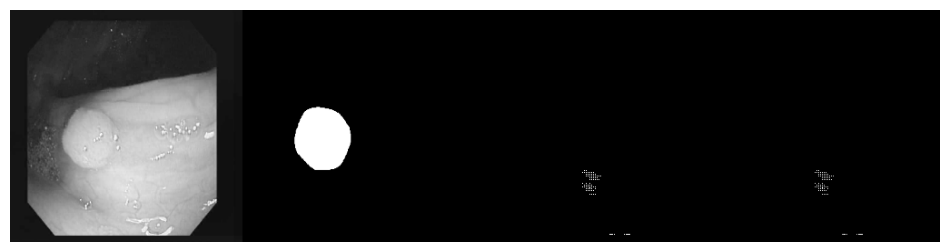

 Epoch: 1 of 100, Iter.: 31 of 31, Train Loss: 0.251985, IoU: 0.258663, Dice: 0.365433
 Epoch: 1 of 100, Iter.: 31 of 31, Valid Loss: 0.373765, IoU: 0.195682, Dice: 0.289879


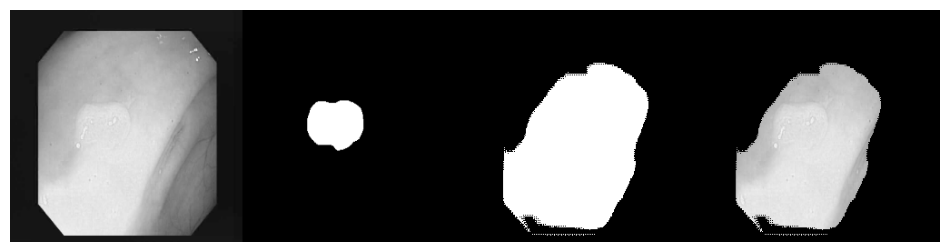

 Epoch: 2 of 100, Iter.: 31 of 31, Train Loss: 0.197098, IoU: 0.297926, Dice: 0.409761
 Epoch: 2 of 100, Iter.: 31 of 31, Valid Loss: 0.387467, IoU: 0.225700, Dice: 0.331667


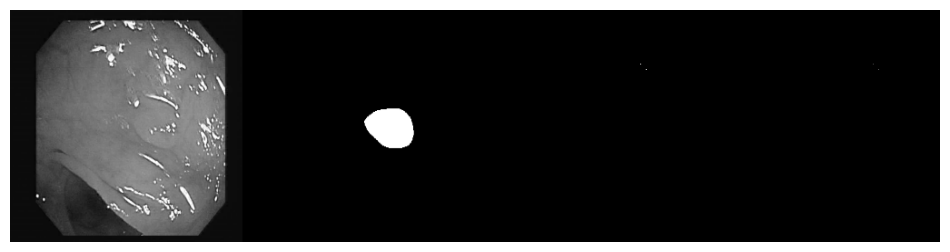

 Epoch: 3 of 100, Iter.: 31 of 31, Train Loss: 0.169091, IoU: 0.314257, Dice: 0.427301
 Epoch: 3 of 100, Iter.: 31 of 31, Valid Loss: 0.199985, IoU: 0.289472, Dice: 0.405756


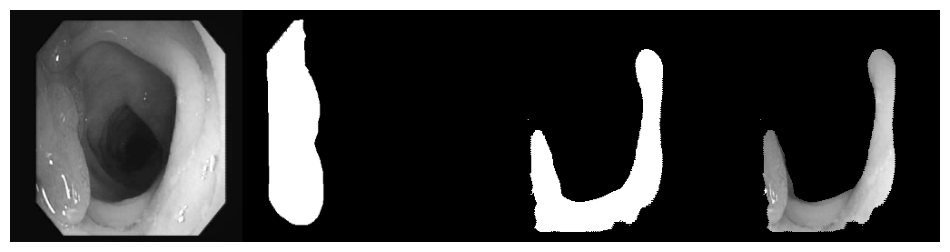

 Epoch: 4 of 100, Iter.: 31 of 31, Train Loss: 0.138937, IoU: 0.336691, Dice: 0.452688
 Epoch: 4 of 100, Iter.: 31 of 31, Valid Loss: 0.381871, IoU: 0.254575, Dice: 0.366625


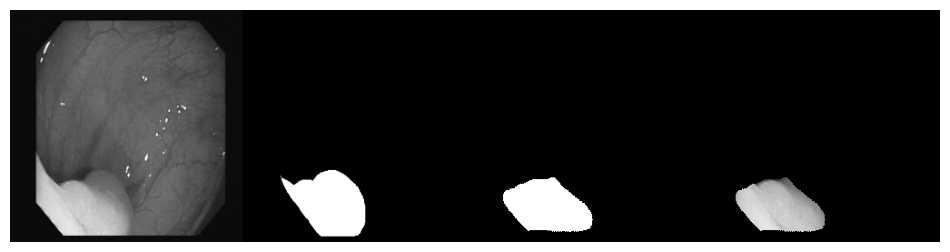

 Epoch: 5 of 100, Iter.: 31 of 31, Train Loss: 0.106878, IoU: 0.358330, Dice: 0.478388
 Epoch: 5 of 100, Iter.: 31 of 31, Valid Loss: 0.146214, IoU: 0.317758, Dice: 0.439650


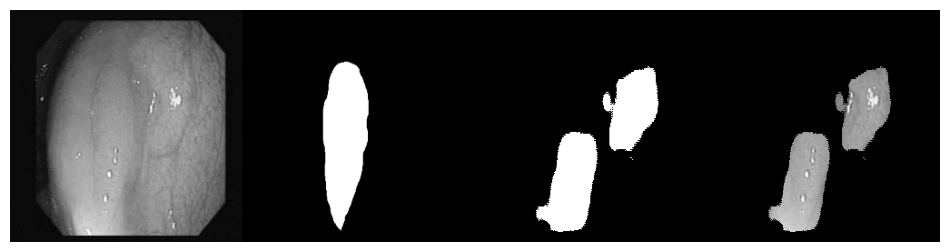

 Epoch: 6 of 100, Iter.: 31 of 31, Train Loss: 0.080852, IoU: 0.377351, Dice: 0.500607
 Epoch: 6 of 100, Iter.: 31 of 31, Valid Loss: 0.147168, IoU: 0.241149, Dice: 0.342506


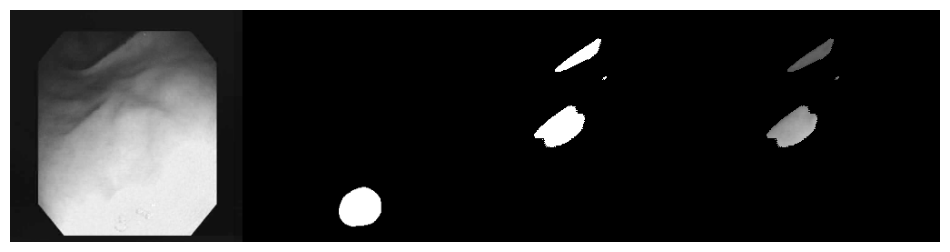

 Epoch: 7 of 100, Iter.: 31 of 31, Train Loss: 0.058850, IoU: 0.397159, Dice: 0.522904
 Epoch: 7 of 100, Iter.: 31 of 31, Valid Loss: 0.127071, IoU: 0.232024, Dice: 0.322236


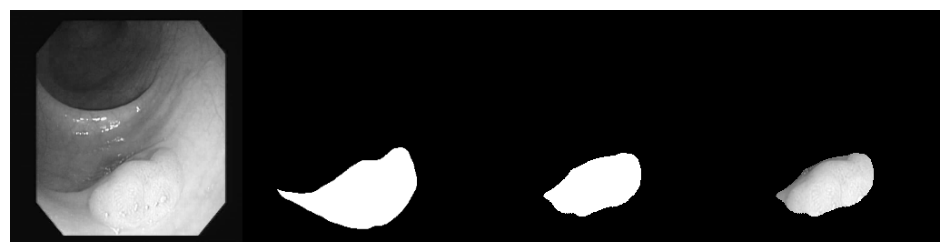

 Epoch: 8 of 100, Iter.: 31 of 31, Train Loss: 0.030470, IoU: 0.415530, Dice: 0.538823
 Epoch: 8 of 100, Iter.: 31 of 31, Valid Loss: 0.121810, IoU: 0.334523, Dice: 0.466973


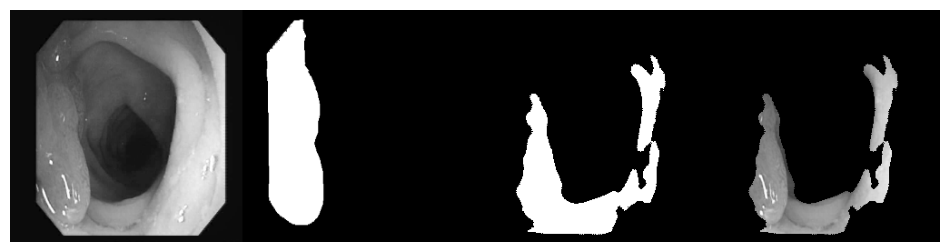

 Epoch: 9 of 100, Iter.: 31 of 31, Train Loss: -0.011775, IoU: 0.458613, Dice: 0.587365
 Epoch: 9 of 100, Iter.: 31 of 31, Valid Loss: 0.139204, IoU: 0.183076, Dice: 0.260945


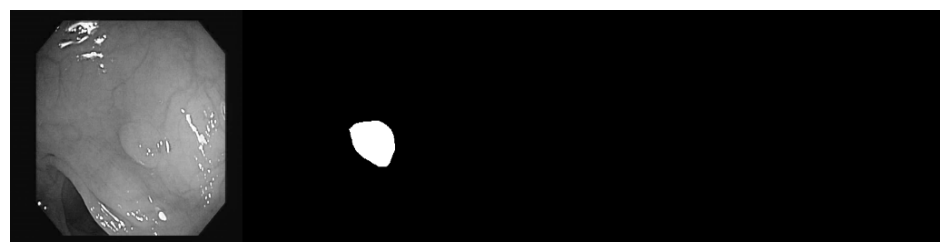

 Epoch: 10 of 100, Iter.: 31 of 31, Train Loss: -0.039910, IoU: 0.479524, Dice: 0.603686
 Epoch: 10 of 100, Iter.: 31 of 31, Valid Loss: 0.049995, IoU: 0.354871, Dice: 0.475724


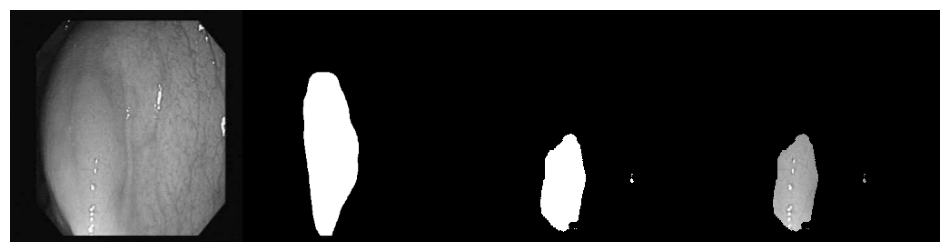

 Epoch: 11 of 100, Iter.: 31 of 31, Train Loss: -0.049819, IoU: 0.486037, Dice: 0.611153
 Epoch: 11 of 100, Iter.: 31 of 31, Valid Loss: 0.003139, IoU: 0.409482, Dice: 0.533908


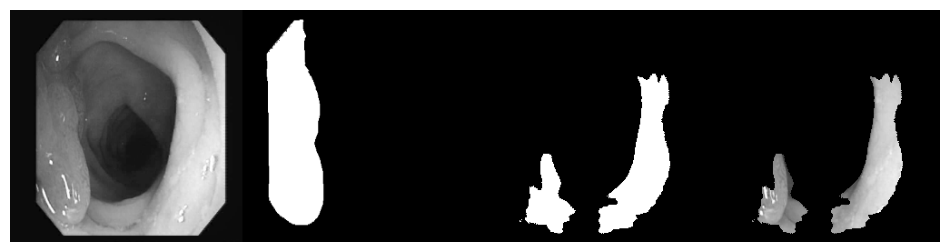

 Epoch: 12 of 100, Iter.: 31 of 31, Train Loss: -0.070817, IoU: 0.492608, Dice: 0.615394
 Epoch: 12 of 100, Iter.: 31 of 31, Valid Loss: 0.060338, IoU: 0.368033, Dice: 0.493123


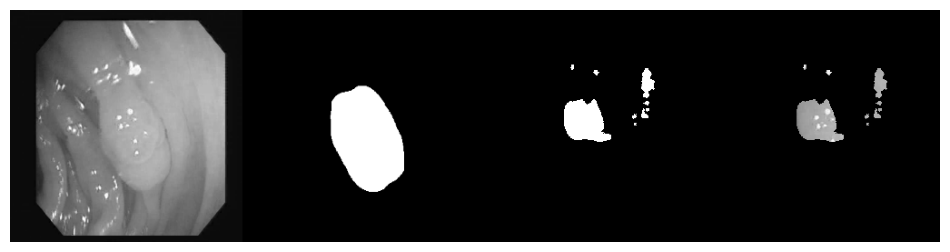

 Epoch: 13 of 100, Iter.: 31 of 31, Train Loss: -0.127963, IoU: 0.550322, Dice: 0.672212
 Epoch: 13 of 100, Iter.: 31 of 31, Valid Loss: 0.130987, IoU: 0.339913, Dice: 0.458808


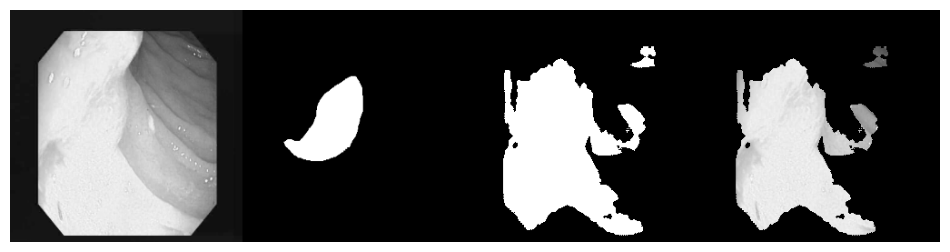

 Epoch: 14 of 100, Iter.: 31 of 31, Train Loss: -0.158674, IoU: 0.577107, Dice: 0.696527
 Epoch: 14 of 100, Iter.: 31 of 31, Valid Loss: -0.047230, IoU: 0.420862, Dice: 0.536469


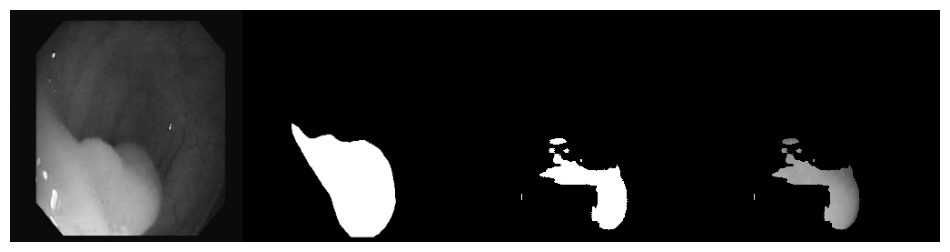

 Epoch: 15 of 100, Iter.: 31 of 31, Train Loss: -0.212991, IoU: 0.625525, Dice: 0.739160
 Epoch: 15 of 100, Iter.: 31 of 31, Valid Loss: -0.051896, IoU: 0.436413, Dice: 0.570354


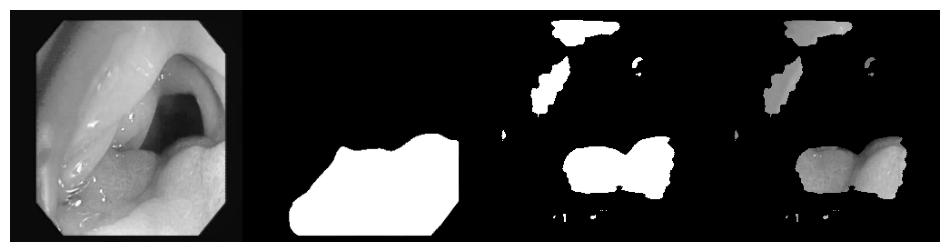

 Epoch: 16 of 100, Iter.: 31 of 31, Train Loss: -0.229139, IoU: 0.623136, Dice: 0.735671
 Epoch: 16 of 100, Iter.: 31 of 31, Valid Loss: -0.040031, IoU: 0.383426, Dice: 0.488040


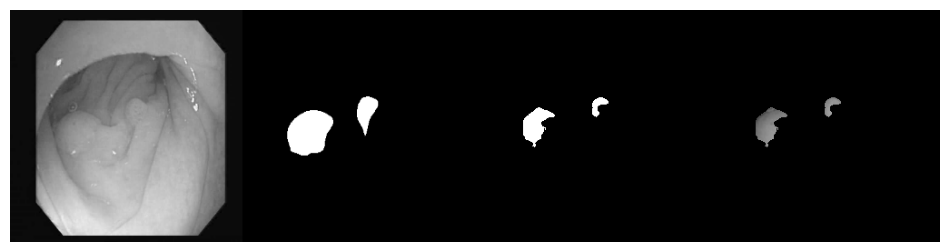

 Epoch: 17 of 100, Iter.: 31 of 31, Train Loss: -0.251379, IoU: 0.636007, Dice: 0.745611
 Epoch: 17 of 100, Iter.: 31 of 31, Valid Loss: -0.090499, IoU: 0.423269, Dice: 0.543641


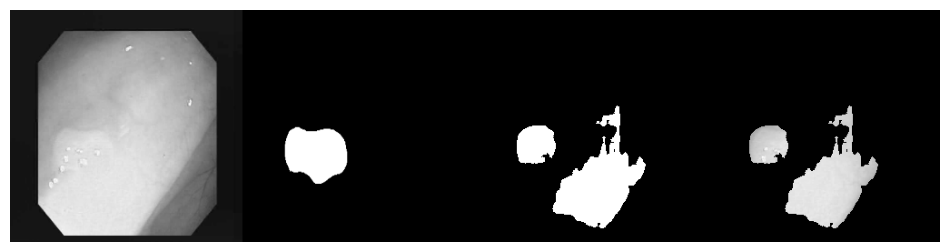

 Epoch: 18 of 100, Iter.: 31 of 31, Train Loss: -0.308362, IoU: 0.674308, Dice: 0.778711
 Epoch: 18 of 100, Iter.: 31 of 31, Valid Loss: -0.095565, IoU: 0.453380, Dice: 0.579482


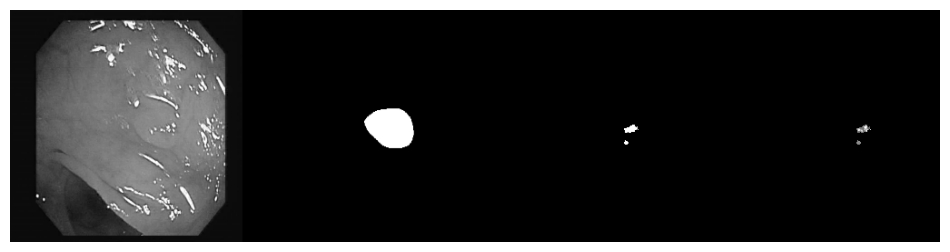

 Epoch: 19 of 100, Iter.: 31 of 31, Train Loss: -0.352322, IoU: 0.720266, Dice: 0.815208
 Epoch: 19 of 100, Iter.: 31 of 31, Valid Loss: -0.148885, IoU: 0.503960, Dice: 0.632719


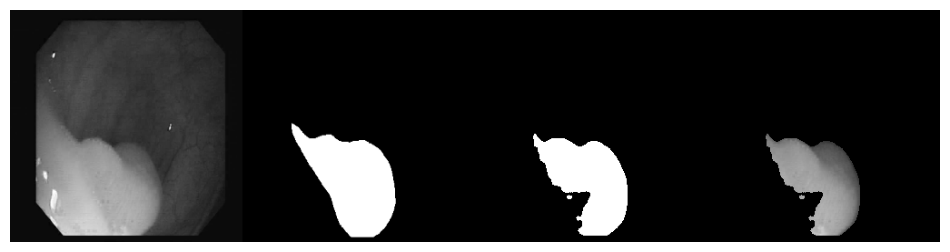

 Epoch: 20 of 100, Iter.: 31 of 31, Train Loss: -0.398369, IoU: 0.753520, Dice: 0.840302
 Epoch: 20 of 100, Iter.: 31 of 31, Valid Loss: -0.078595, IoU: 0.414078, Dice: 0.530770


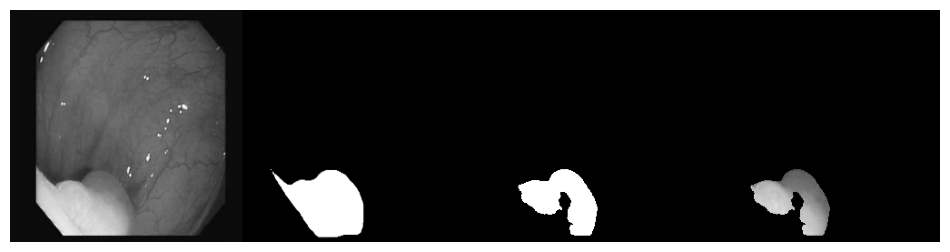

 Epoch: 21 of 100, Iter.: 31 of 31, Train Loss: -0.418160, IoU: 0.754895, Dice: 0.840814
 Epoch: 21 of 100, Iter.: 31 of 31, Valid Loss: -0.121285, IoU: 0.443154, Dice: 0.557024


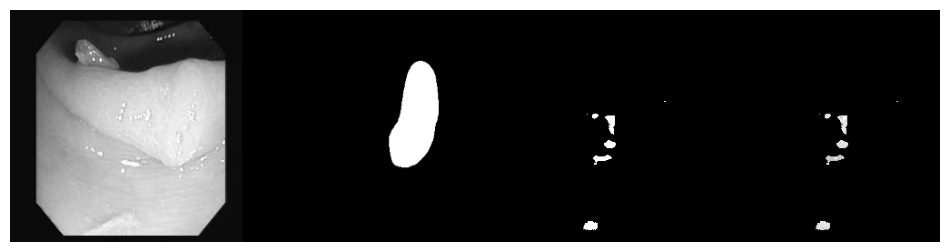

 Epoch: 22 of 100, Iter.: 31 of 31, Train Loss: -0.439978, IoU: 0.771745, Dice: 0.853915
 Epoch: 22 of 100, Iter.: 31 of 31, Valid Loss: -0.119320, IoU: 0.398192, Dice: 0.514030


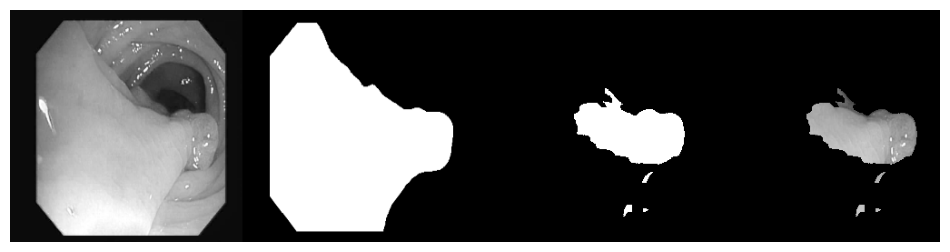

 Epoch: 23 of 100, Iter.: 31 of 31, Train Loss: -0.477464, IoU: 0.784329, Dice: 0.861261
 Epoch: 23 of 100, Iter.: 31 of 31, Valid Loss: -0.130848, IoU: 0.407832, Dice: 0.522901


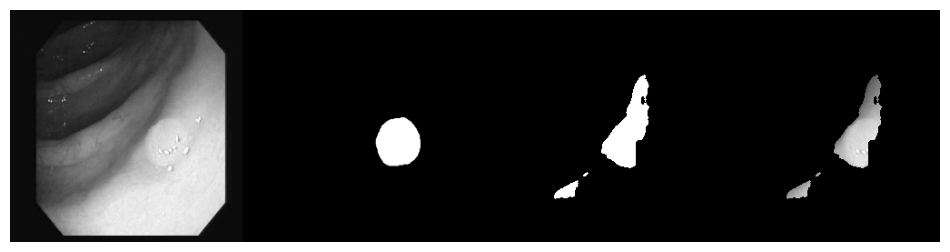

 Epoch: 24 of 100, Iter.: 31 of 31, Train Loss: -0.507307, IoU: 0.798035, Dice: 0.870953
 Epoch: 24 of 100, Iter.: 31 of 31, Valid Loss: -0.095270, IoU: 0.413728, Dice: 0.529754


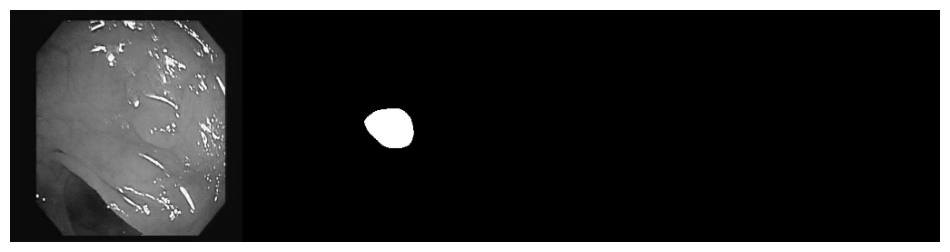

 Epoch: 25 of 100, Iter.: 31 of 31, Train Loss: -0.528721, IoU: 0.801134, Dice: 0.873536
 Epoch: 25 of 100, Iter.: 31 of 31, Valid Loss: -0.011340, IoU: 0.280508, Dice: 0.377811


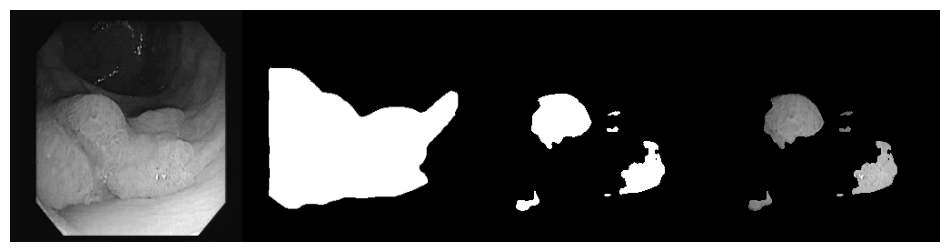

 Epoch: 26 of 100, Iter.: 31 of 31, Train Loss: -0.529383, IoU: 0.790695, Dice: 0.867407
 Epoch: 26 of 100, Iter.: 31 of 31, Valid Loss: -0.184320, IoU: 0.460225, Dice: 0.576604


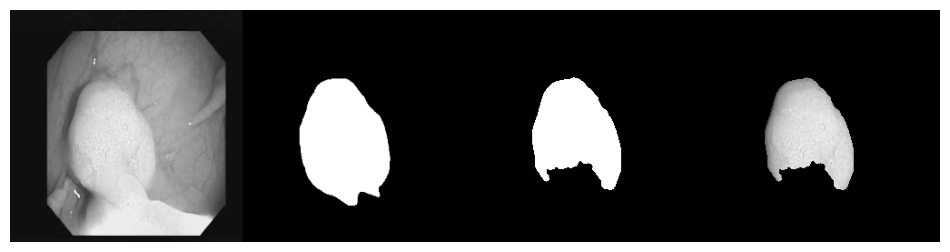

 Epoch: 27 of 100, Iter.: 31 of 31, Train Loss: -0.585008, IoU: 0.821995, Dice: 0.886255
 Epoch: 27 of 100, Iter.: 31 of 31, Valid Loss: -0.061462, IoU: 0.286328, Dice: 0.383217


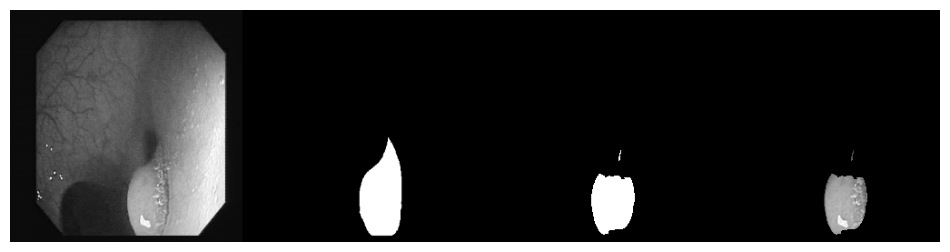

 Epoch: 28 of 100, Iter.: 31 of 31, Train Loss: -0.608254, IoU: 0.835300, Dice: 0.898199
 Epoch: 28 of 100, Iter.: 31 of 31, Valid Loss: -0.241556, IoU: 0.486952, Dice: 0.604023


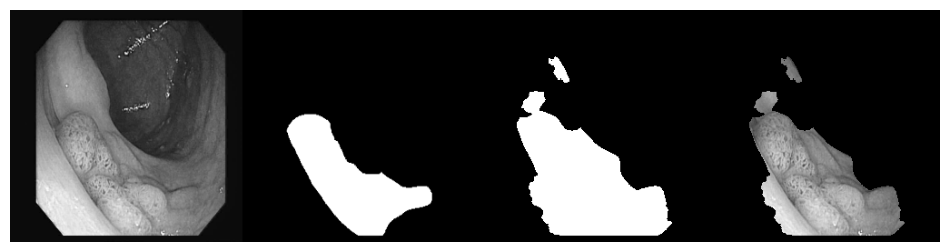

 Epoch: 29 of 100, Iter.: 31 of 31, Train Loss: -0.621534, IoU: 0.834381, Dice: 0.896152
 Epoch: 29 of 100, Iter.: 31 of 31, Valid Loss: -0.148442, IoU: 0.441931, Dice: 0.559249


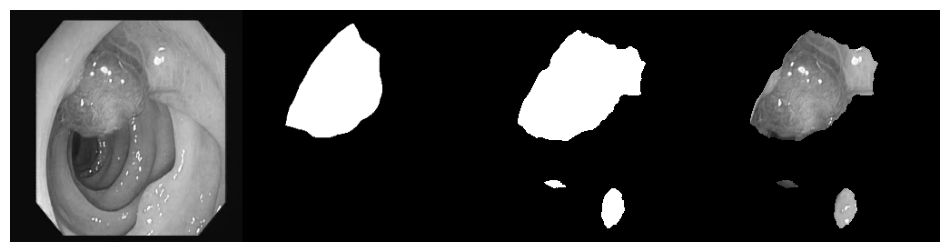

 Epoch: 30 of 100, Iter.: 31 of 31, Train Loss: -0.622529, IoU: 0.817660, Dice: 0.884926
 Epoch: 30 of 100, Iter.: 31 of 31, Valid Loss: -0.149476, IoU: 0.407843, Dice: 0.511562


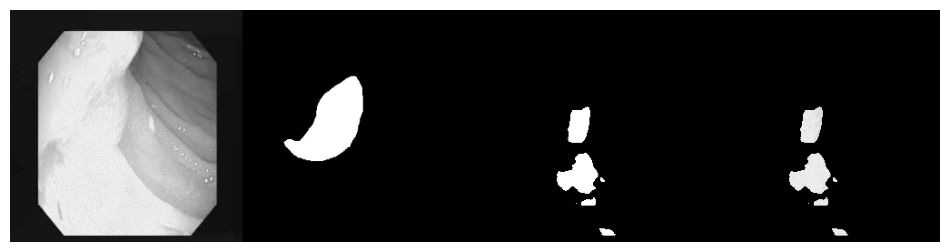

 Epoch: 31 of 100, Iter.: 31 of 31, Train Loss: -0.664789, IoU: 0.850347, Dice: 0.908026
 Epoch: 31 of 100, Iter.: 31 of 31, Valid Loss: -0.310672, IoU: 0.522260, Dice: 0.630629


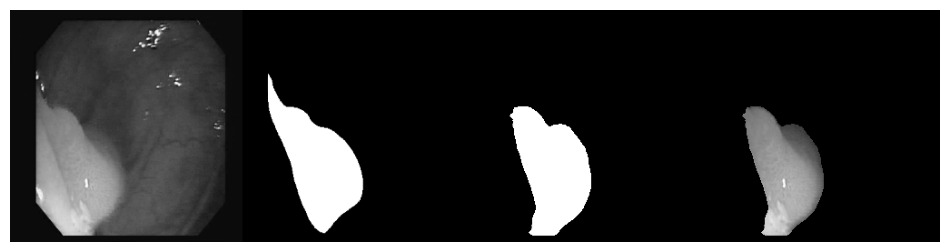

 Epoch: 32 of 100, Iter.: 31 of 31, Train Loss: -0.693772, IoU: 0.868825, Dice: 0.920258
 Epoch: 32 of 100, Iter.: 31 of 31, Valid Loss: -0.332955, IoU: 0.539177, Dice: 0.649994


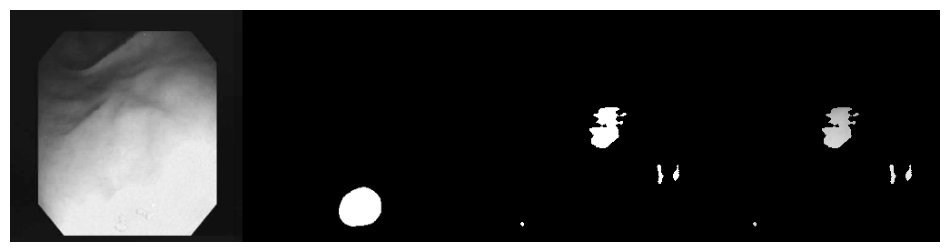

 Epoch: 33 of 100, Iter.: 31 of 31, Train Loss: -0.690806, IoU: 0.854475, Dice: 0.910264
 Epoch: 33 of 100, Iter.: 31 of 31, Valid Loss: -0.223682, IoU: 0.442166, Dice: 0.545876


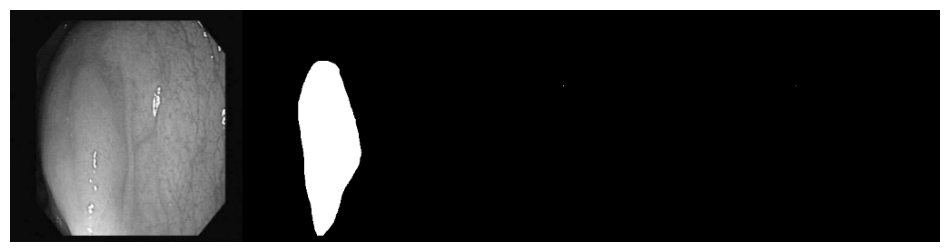

 Epoch: 34 of 100, Iter.: 31 of 31, Train Loss: -0.720042, IoU: 0.867451, Dice: 0.919293
 Epoch: 34 of 100, Iter.: 31 of 31, Valid Loss: -0.202897, IoU: 0.427268, Dice: 0.541429


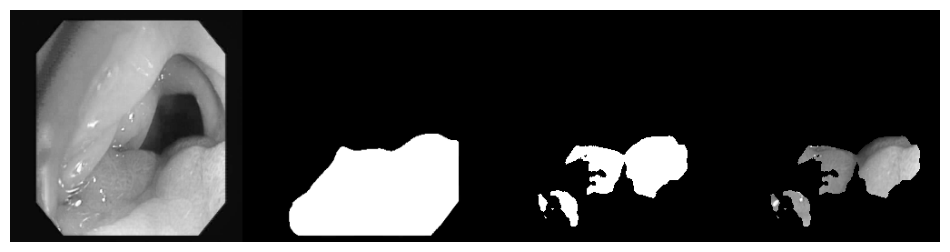

 Epoch: 35 of 100, Iter.: 31 of 31, Train Loss: -0.744441, IoU: 0.880260, Dice: 0.927142
 Epoch: 35 of 100, Iter.: 31 of 31, Valid Loss: -0.317152, IoU: 0.505918, Dice: 0.616367


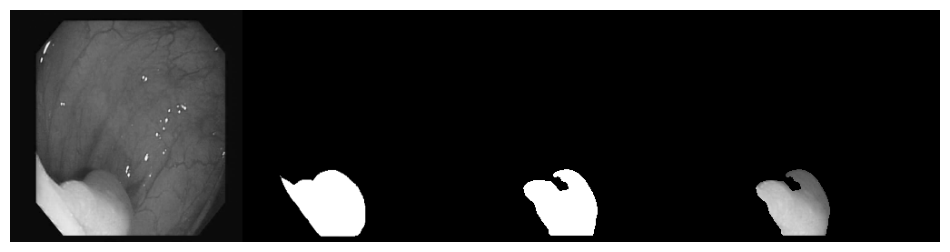

 Epoch: 36 of 100, Iter.: 31 of 31, Train Loss: -0.750696, IoU: 0.880366, Dice: 0.927081
 Epoch: 36 of 100, Iter.: 31 of 31, Valid Loss: -0.237203, IoU: 0.464827, Dice: 0.573745


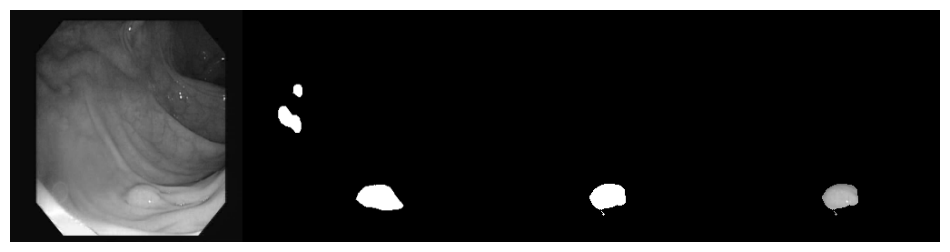

 Epoch: 37 of 100, Iter.: 31 of 31, Train Loss: -0.772113, IoU: 0.889748, Dice: 0.933055
 Epoch: 37 of 100, Iter.: 31 of 31, Valid Loss: -0.327908, IoU: 0.547424, Dice: 0.660812


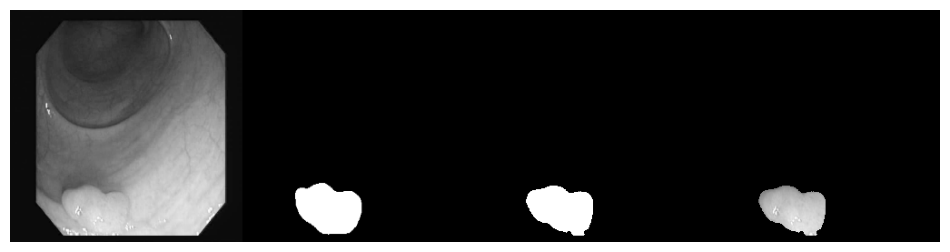

 Epoch: 38 of 100, Iter.: 31 of 31, Train Loss: -0.785125, IoU: 0.892980, Dice: 0.935160
 Epoch: 38 of 100, Iter.: 31 of 31, Valid Loss: -0.248249, IoU: 0.466034, Dice: 0.572022


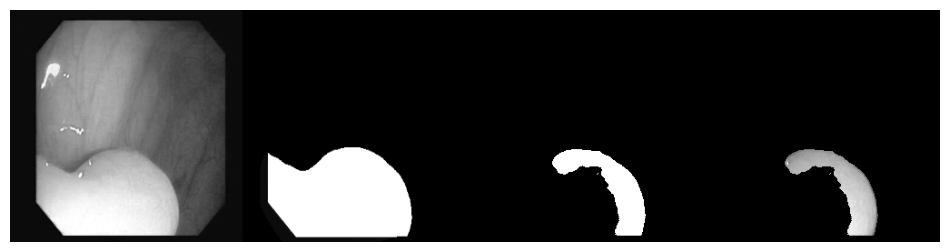

 Epoch: 39 of 100, Iter.: 31 of 31, Train Loss: -0.805388, IoU: 0.903333, Dice: 0.940688
 Epoch: 39 of 100, Iter.: 31 of 31, Valid Loss: -0.245565, IoU: 0.455027, Dice: 0.565100


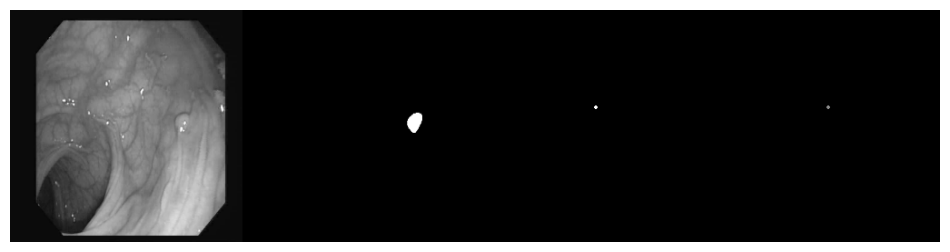

 Epoch: 40 of 100, Iter.: 31 of 31, Train Loss: -0.825967, IoU: 0.915269, Dice: 0.948485
 Epoch: 40 of 100, Iter.: 31 of 31, Valid Loss: -0.364541, IoU: 0.552504, Dice: 0.658358


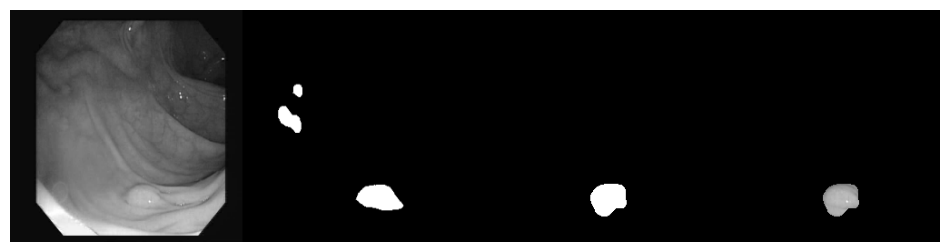

 Epoch: 41 of 100, Iter.: 31 of 31, Train Loss: -0.828118, IoU: 0.917831, Dice: 0.951421
 Epoch: 41 of 100, Iter.: 31 of 31, Valid Loss: -0.374127, IoU: 0.548697, Dice: 0.660061


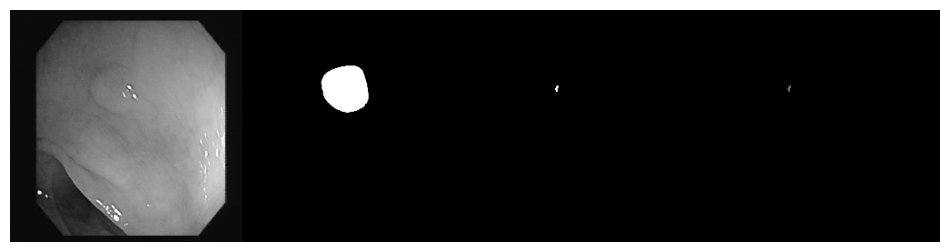

 Epoch: 42 of 100, Iter.: 31 of 31, Train Loss: -0.827690, IoU: 0.911183, Dice: 0.947456
 Epoch: 42 of 100, Iter.: 31 of 31, Valid Loss: -0.369742, IoU: 0.571998, Dice: 0.684984


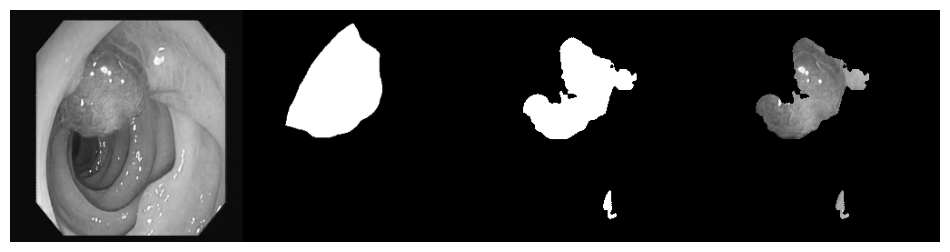

 Epoch: 43 of 100, Iter.: 31 of 31, Train Loss: -0.820412, IoU: 0.899744, Dice: 0.940150
 Epoch: 43 of 100, Iter.: 31 of 31, Valid Loss: -0.326796, IoU: 0.516699, Dice: 0.621611


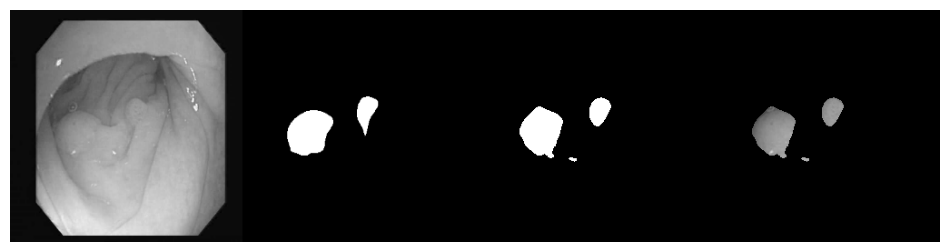

 Epoch: 44 of 100, Iter.: 31 of 31, Train Loss: -0.838128, IoU: 0.904771, Dice: 0.943184
 Epoch: 44 of 100, Iter.: 31 of 31, Valid Loss: -0.349584, IoU: 0.552661, Dice: 0.668463


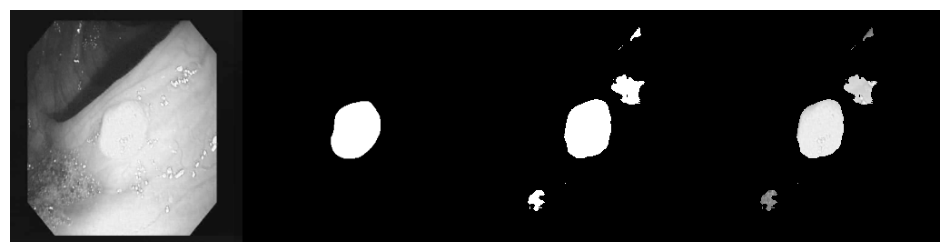

 Epoch: 45 of 100, Iter.: 31 of 31, Train Loss: -0.836932, IoU: 0.905654, Dice: 0.943538
 Epoch: 45 of 100, Iter.: 31 of 31, Valid Loss: -0.323528, IoU: 0.505295, Dice: 0.620243


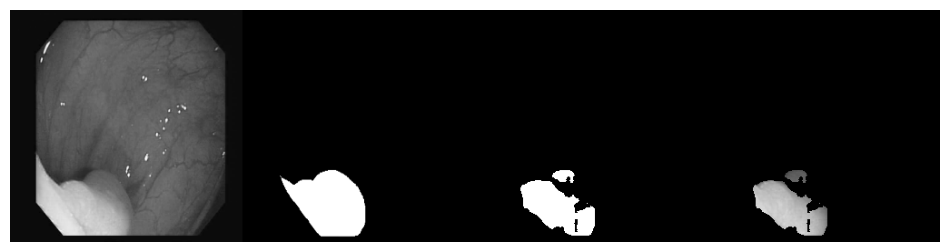

 Epoch: 46 of 100, Iter.: 31 of 31, Train Loss: -0.851334, IoU: 0.912478, Dice: 0.948166
 Epoch: 46 of 100, Iter.: 31 of 31, Valid Loss: -0.285066, IoU: 0.489354, Dice: 0.597612


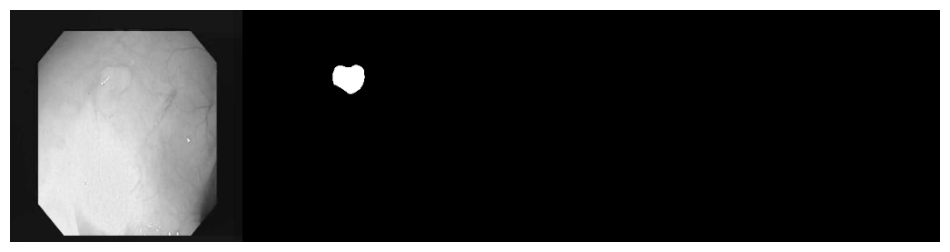

 Epoch: 47 of 100, Iter.: 31 of 31, Train Loss: -0.862742, IoU: 0.921818, Dice: 0.953285
 Epoch: 47 of 100, Iter.: 31 of 31, Valid Loss: -0.346157, IoU: 0.542441, Dice: 0.649390


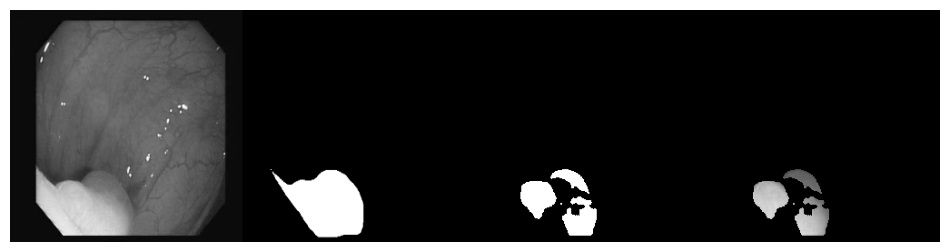

 Epoch: 48 of 100, Iter.: 31 of 31, Train Loss: -0.874643, IoU: 0.928253, Dice: 0.957919
 Epoch: 48 of 100, Iter.: 31 of 31, Valid Loss: -0.394552, IoU: 0.581571, Dice: 0.695859


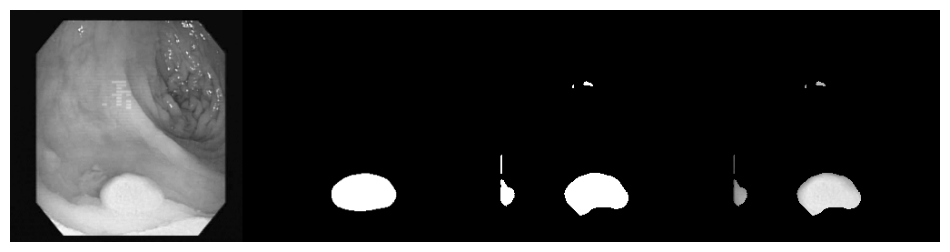

 Epoch: 49 of 100, Iter.: 31 of 31, Train Loss: -0.880174, IoU: 0.932668, Dice: 0.961287
 Epoch: 49 of 100, Iter.: 31 of 31, Valid Loss: -0.305095, IoU: 0.499125, Dice: 0.605233


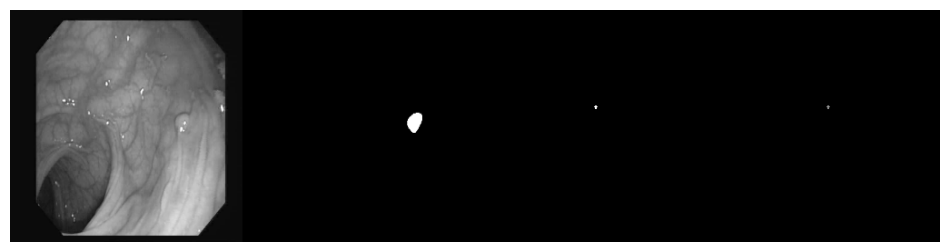

 Epoch: 50 of 100, Iter.: 31 of 31, Train Loss: -0.885361, IoU: 0.935589, Dice: 0.962935
 Epoch: 50 of 100, Iter.: 31 of 31, Valid Loss: -0.356565, IoU: 0.535793, Dice: 0.643616


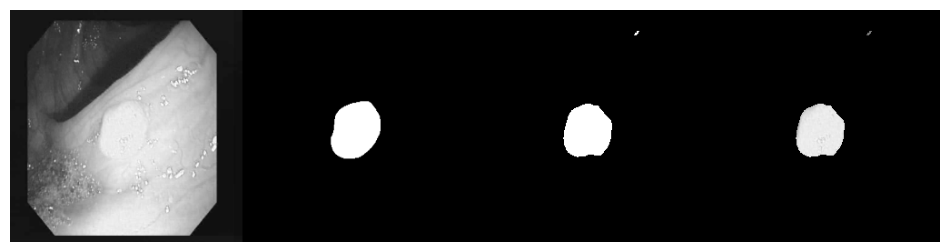

 Epoch: 51 of 100, Iter.: 31 of 31, Train Loss: -0.896504, IoU: 0.942950, Dice: 0.967823
 Epoch: 51 of 100, Iter.: 31 of 31, Valid Loss: -0.338733, IoU: 0.526962, Dice: 0.636155


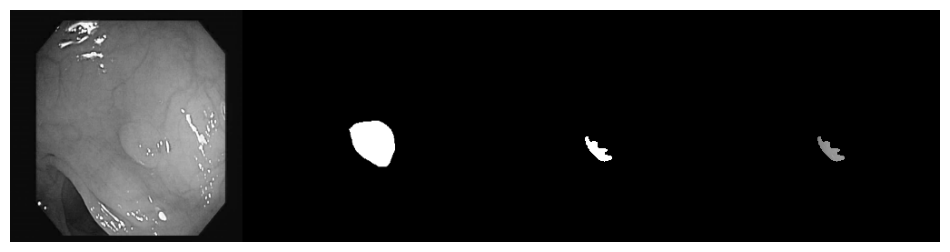

 Epoch: 52 of 100, Iter.: 31 of 31, Train Loss: -0.901348, IoU: 0.945625, Dice: 0.969498
 Epoch: 52 of 100, Iter.: 31 of 31, Valid Loss: -0.328905, IoU: 0.513317, Dice: 0.621311


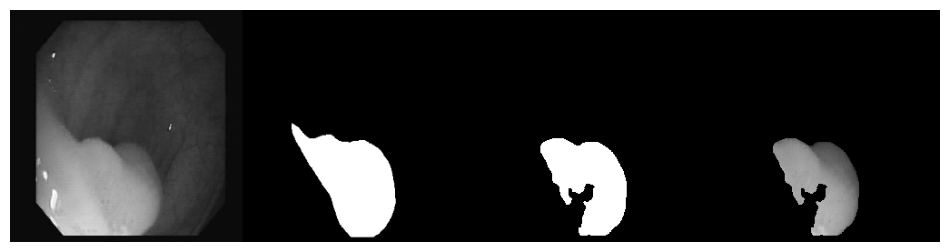

 Epoch: 53 of 100, Iter.: 31 of 31, Train Loss: -0.904460, IoU: 0.947162, Dice: 0.970371
 Epoch: 53 of 100, Iter.: 31 of 31, Valid Loss: -0.343010, IoU: 0.542638, Dice: 0.652599


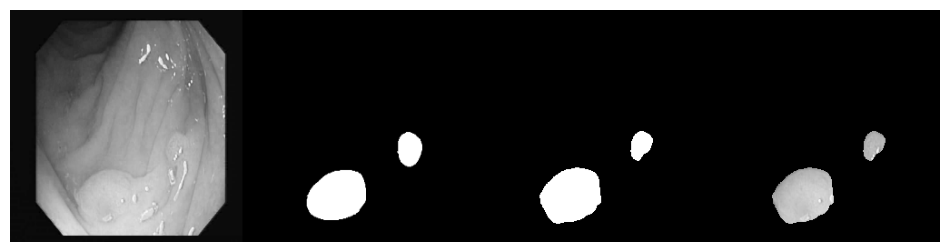

 Epoch: 54 of 100, Iter.: 31 of 31, Train Loss: -0.906899, IoU: 0.948602, Dice: 0.971117
 Epoch: 54 of 100, Iter.: 31 of 31, Valid Loss: -0.414951, IoU: 0.585406, Dice: 0.697115


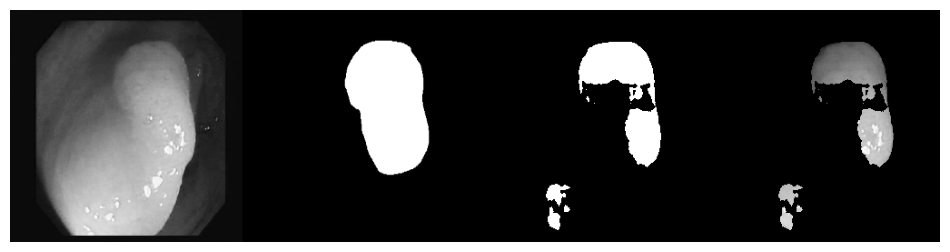

 Epoch: 55 of 100, Iter.: 31 of 31, Train Loss: -0.914754, IoU: 0.952813, Dice: 0.973367
 Epoch: 55 of 100, Iter.: 31 of 31, Valid Loss: -0.351170, IoU: 0.537176, Dice: 0.647498


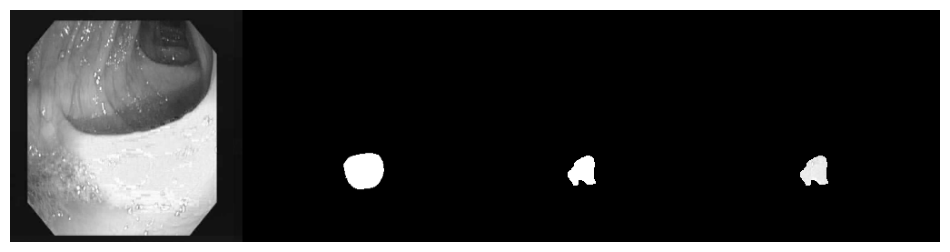

 Epoch: 56 of 100, Iter.: 31 of 31, Train Loss: -0.915209, IoU: 0.950601, Dice: 0.971850
 Epoch: 56 of 100, Iter.: 31 of 31, Valid Loss: -0.353969, IoU: 0.545593, Dice: 0.659897


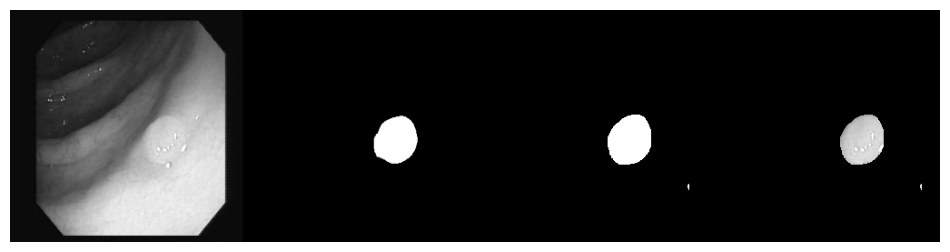

 Epoch: 57 of 100, Iter.: 31 of 31, Train Loss: -0.910642, IoU: 0.944785, Dice: 0.968627
 Epoch: 57 of 100, Iter.: 31 of 31, Valid Loss: -0.351655, IoU: 0.550466, Dice: 0.660140


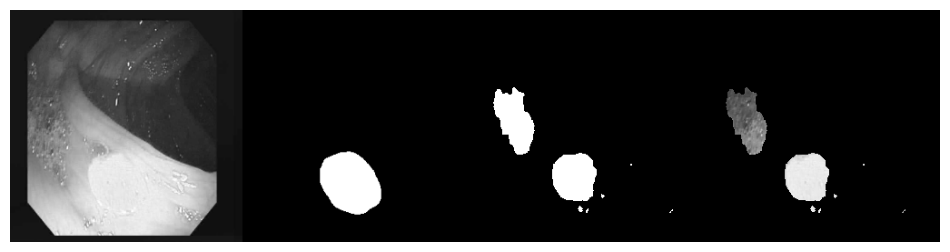

 Epoch: 58 of 100, Iter.: 31 of 31, Train Loss: -0.877109, IoU: 0.915469, Dice: 0.950669
 Epoch: 58 of 100, Iter.: 31 of 31, Valid Loss: -0.297940, IoU: 0.515197, Dice: 0.630906


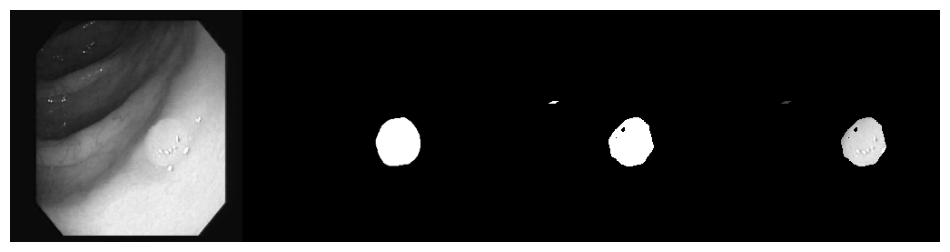

 Epoch: 59 of 100, Iter.: 31 of 31, Train Loss: -0.867947, IoU: 0.903250, Dice: 0.943892
 Epoch: 59 of 100, Iter.: 31 of 31, Valid Loss: -0.270288, IoU: 0.494753, Dice: 0.611604


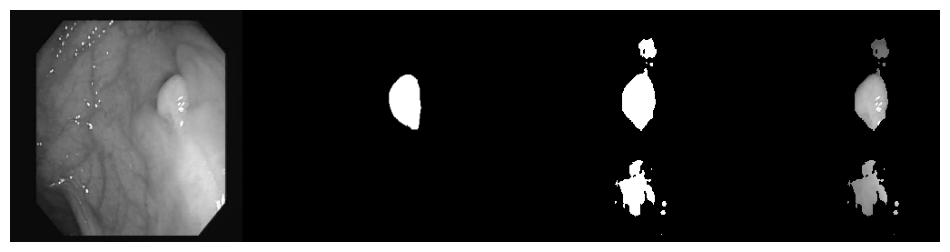

 Epoch: 60 of 100, Iter.: 31 of 31, Train Loss: -0.790650, IoU: 0.849383, Dice: 0.906409
 Epoch: 60 of 100, Iter.: 31 of 31, Valid Loss: -0.081858, IoU: 0.343169, Dice: 0.455121


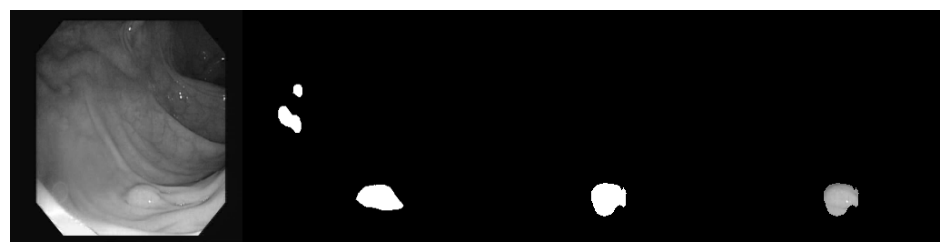

 Epoch: 61 of 100, Iter.: 31 of 31, Train Loss: -0.784502, IoU: 0.845962, Dice: 0.906040
 Epoch: 61 of 100, Iter.: 31 of 31, Valid Loss: -0.232965, IoU: 0.487113, Dice: 0.601293


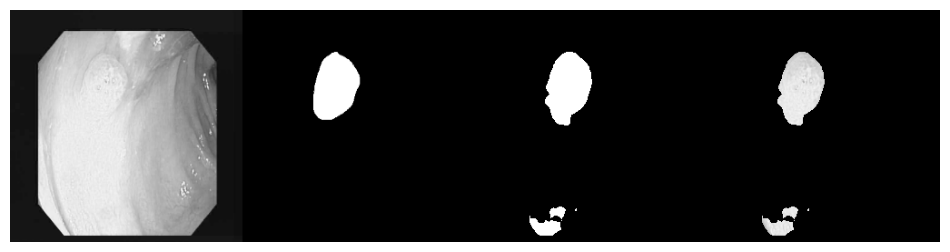

 Epoch: 62 of 100, Iter.: 31 of 31, Train Loss: -0.869392, IoU: 0.900968, Dice: 0.941601
 Epoch: 62 of 100, Iter.: 31 of 31, Valid Loss: -0.212440, IoU: 0.464414, Dice: 0.579867


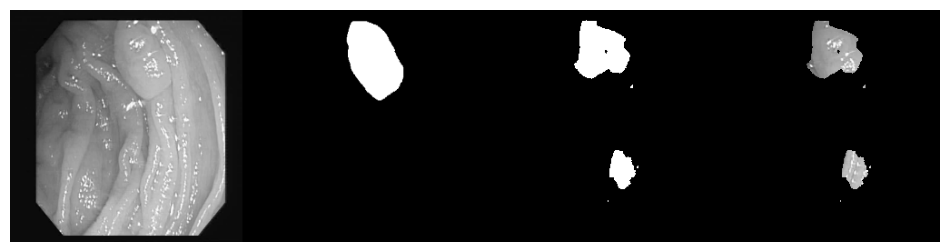

 Epoch: 63 of 100, Iter.: 31 of 31, Train Loss: -0.895476, IoU: 0.923868, Dice: 0.957048
 Epoch: 63 of 100, Iter.: 31 of 31, Valid Loss: -0.186895, IoU: 0.425951, Dice: 0.524638


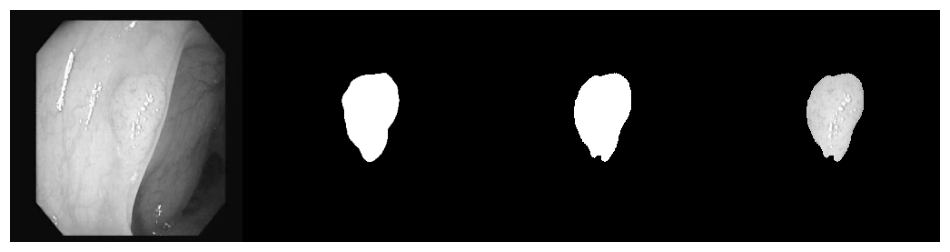

 Epoch: 64 of 100, Iter.: 31 of 31, Train Loss: -0.905360, IoU: 0.933212, Dice: 0.962330
 Epoch: 64 of 100, Iter.: 31 of 31, Valid Loss: -0.317308, IoU: 0.520114, Dice: 0.629584


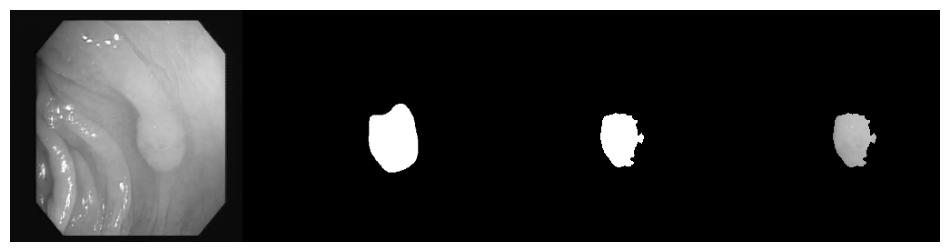

 Epoch: 65 of 100, Iter.: 31 of 31, Train Loss: -0.919571, IoU: 0.944703, Dice: 0.968965
 Epoch: 65 of 100, Iter.: 31 of 31, Valid Loss: -0.354481, IoU: 0.553871, Dice: 0.662925


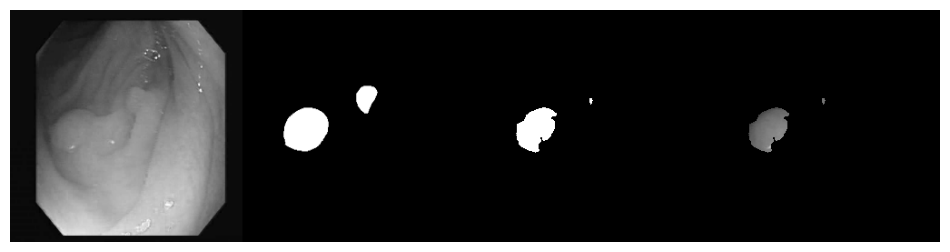

 Epoch: 66 of 100, Iter.: 31 of 31, Train Loss: -0.865842, IoU: 0.905329, Dice: 0.945021
 Epoch: 66 of 100, Iter.: 31 of 31, Valid Loss: -0.241687, IoU: 0.449621, Dice: 0.554728


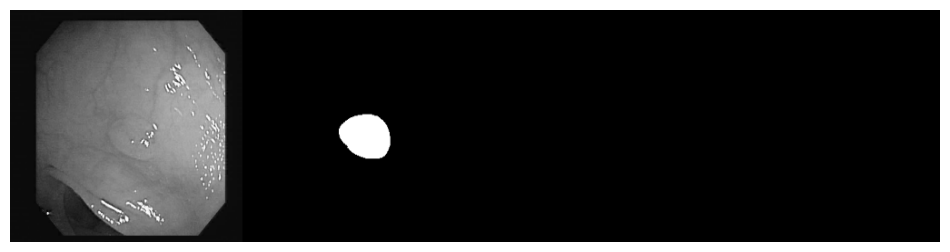

 Epoch: 67 of 100, Iter.: 31 of 31, Train Loss: -0.900826, IoU: 0.927034, Dice: 0.958684
 Epoch: 67 of 100, Iter.: 31 of 31, Valid Loss: -0.250245, IoU: 0.466896, Dice: 0.571958


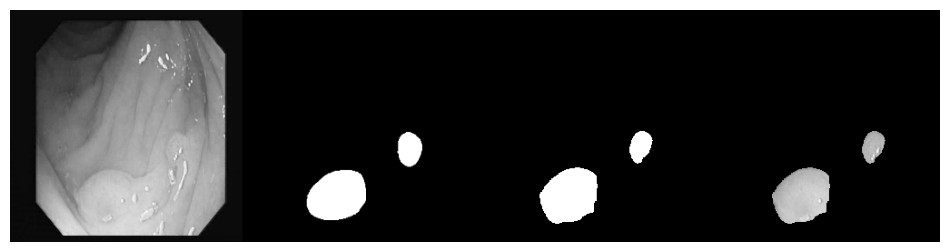

 Epoch: 68 of 100, Iter.: 31 of 31, Train Loss: -0.918529, IoU: 0.942786, Dice: 0.967938
 Epoch: 68 of 100, Iter.: 31 of 31, Valid Loss: -0.319885, IoU: 0.536259, Dice: 0.649031


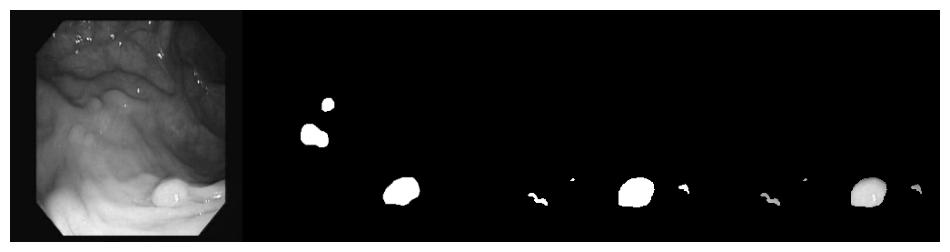

 Epoch: 69 of 100, Iter.: 31 of 31, Train Loss: -0.929885, IoU: 0.951923, Dice: 0.972929
 Epoch: 69 of 100, Iter.: 31 of 31, Valid Loss: -0.333885, IoU: 0.542829, Dice: 0.655282


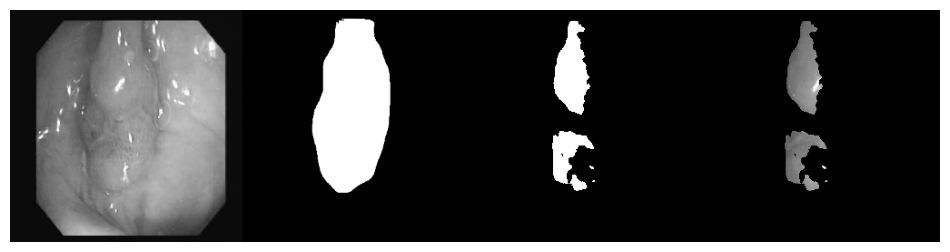

 Epoch: 70 of 100, Iter.: 31 of 31, Train Loss: -0.934756, IoU: 0.955859, Dice: 0.975047
 Epoch: 70 of 100, Iter.: 31 of 31, Valid Loss: -0.335787, IoU: 0.528747, Dice: 0.640289


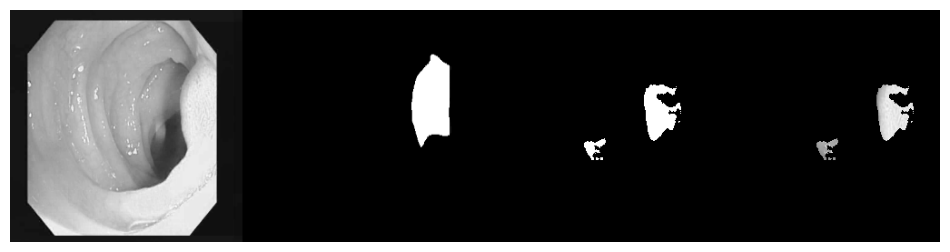

 Epoch: 71 of 100, Iter.: 31 of 31, Train Loss: -0.941807, IoU: 0.960354, Dice: 0.977412
 Epoch: 71 of 100, Iter.: 31 of 31, Valid Loss: -0.375174, IoU: 0.574520, Dice: 0.685788


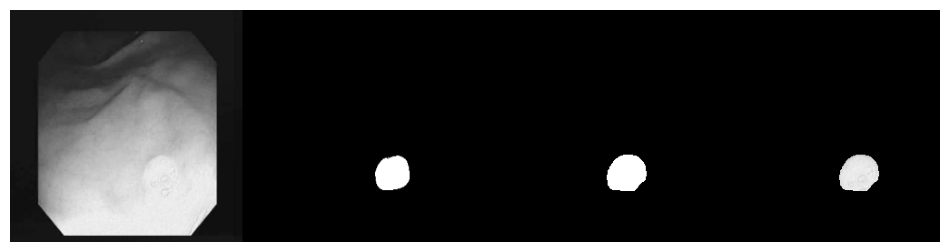

 Epoch: 72 of 100, Iter.: 31 of 31, Train Loss: -0.944726, IoU: 0.963544, Dice: 0.979125
 Epoch: 72 of 100, Iter.: 31 of 31, Valid Loss: -0.337630, IoU: 0.544542, Dice: 0.657039


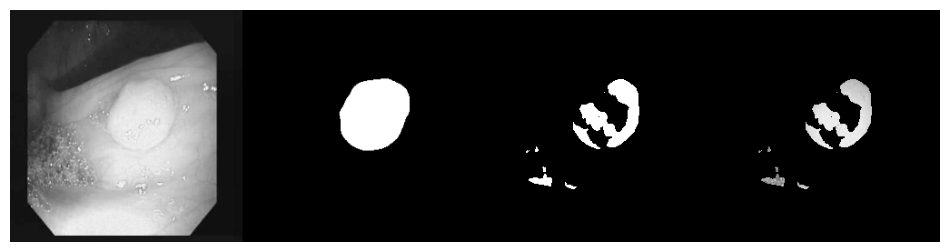

 Epoch: 73 of 100, Iter.: 31 of 31, Train Loss: -0.946986, IoU: 0.965189, Dice: 0.979997
 Epoch: 73 of 100, Iter.: 31 of 31, Valid Loss: -0.349691, IoU: 0.552515, Dice: 0.663254


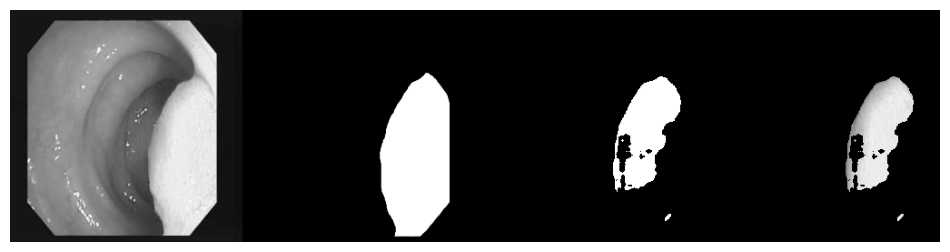

 Epoch: 74 of 100, Iter.: 31 of 31, Train Loss: -0.948161, IoU: 0.965753, Dice: 0.980307
 Epoch: 74 of 100, Iter.: 31 of 31, Valid Loss: -0.324378, IoU: 0.539441, Dice: 0.651783


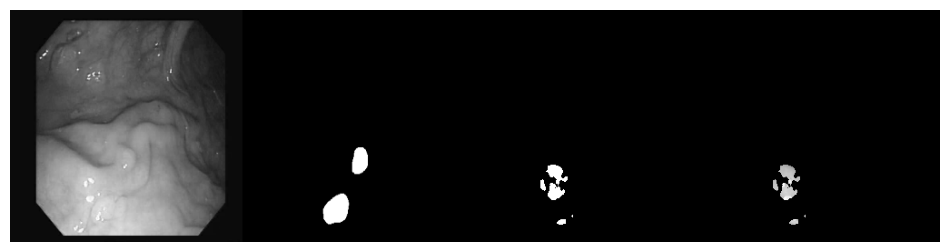

 Epoch: 75 of 100, Iter.: 31 of 31, Train Loss: -0.950954, IoU: 0.967873, Dice: 0.981418
 Epoch: 75 of 100, Iter.: 31 of 31, Valid Loss: -0.332815, IoU: 0.546196, Dice: 0.659907


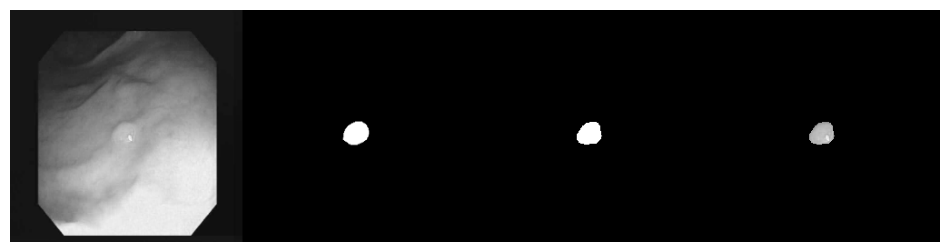

 Epoch: 76 of 100, Iter.: 31 of 31, Train Loss: -0.953113, IoU: 0.968966, Dice: 0.981971
 Epoch: 76 of 100, Iter.: 31 of 31, Valid Loss: -0.319212, IoU: 0.540402, Dice: 0.655375


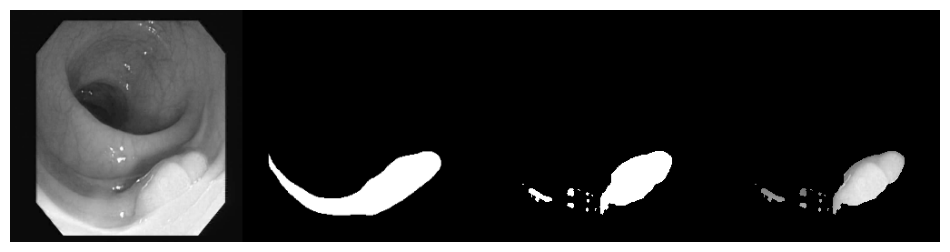

 Epoch: 77 of 100, Iter.: 31 of 31, Train Loss: -0.954022, IoU: 0.969595, Dice: 0.982316
 Epoch: 77 of 100, Iter.: 31 of 31, Valid Loss: -0.337254, IoU: 0.551660, Dice: 0.666131


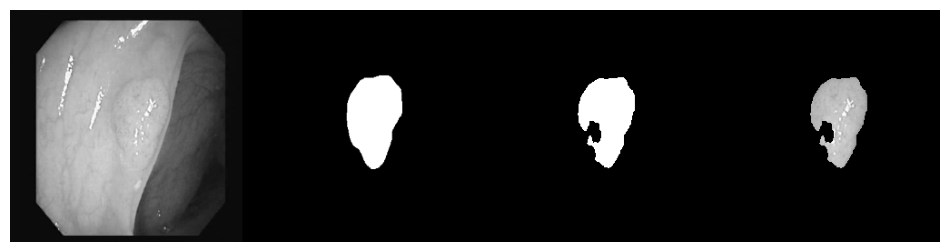

 Epoch: 78 of 100, Iter.: 31 of 31, Train Loss: -0.955239, IoU: 0.969768, Dice: 0.982398
 Epoch: 78 of 100, Iter.: 31 of 31, Valid Loss: -0.336899, IoU: 0.555961, Dice: 0.670930


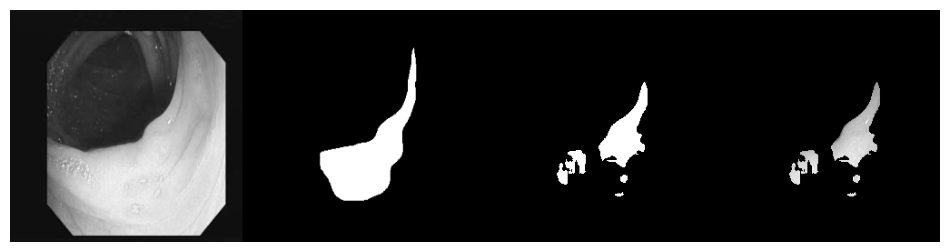

 Epoch: 79 of 100, Iter.: 31 of 31, Train Loss: -0.956085, IoU: 0.969972, Dice: 0.982502
 Epoch: 79 of 100, Iter.: 31 of 31, Valid Loss: -0.306261, IoU: 0.527941, Dice: 0.641345


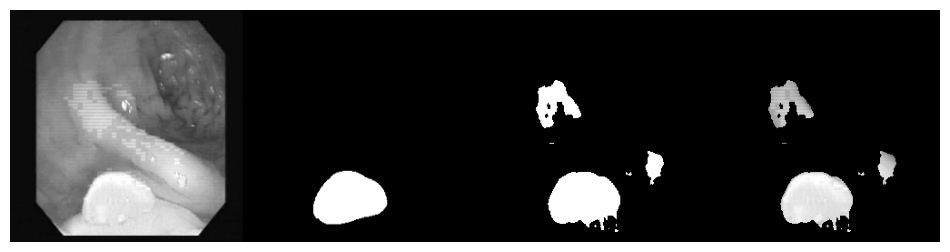

 Epoch: 80 of 100, Iter.: 31 of 31, Train Loss: -0.958280, IoU: 0.971856, Dice: 0.983587
 Epoch: 80 of 100, Iter.: 31 of 31, Valid Loss: -0.314638, IoU: 0.536708, Dice: 0.651850


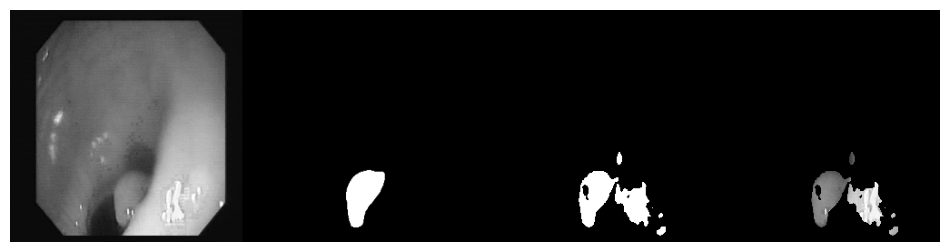

 Epoch: 81 of 100, Iter.: 31 of 31, Train Loss: -0.960502, IoU: 0.972814, Dice: 0.984097
 Epoch: 81 of 100, Iter.: 31 of 31, Valid Loss: -0.304319, IoU: 0.529723, Dice: 0.646451


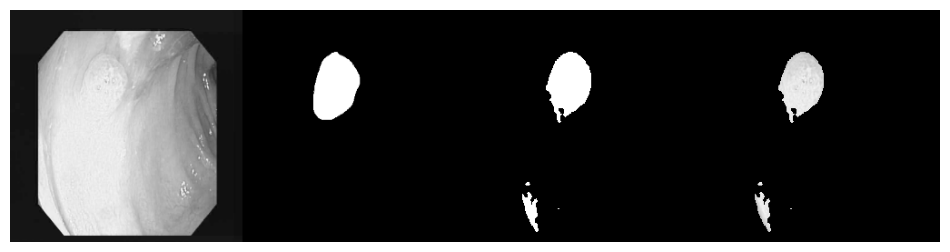

 Epoch: 82 of 100, Iter.: 31 of 31, Train Loss: -0.961642, IoU: 0.973552, Dice: 0.984567
 Epoch: 82 of 100, Iter.: 31 of 31, Valid Loss: -0.315898, IoU: 0.539338, Dice: 0.654732


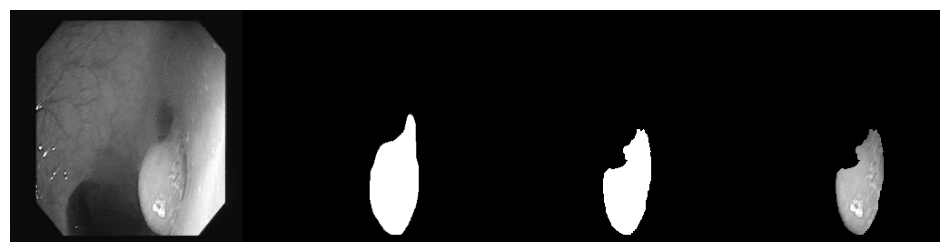

 Epoch: 83 of 100, Iter.: 31 of 31, Train Loss: -0.961378, IoU: 0.973541, Dice: 0.984531
 Epoch: 83 of 100, Iter.: 31 of 31, Valid Loss: -0.300662, IoU: 0.533698, Dice: 0.647917


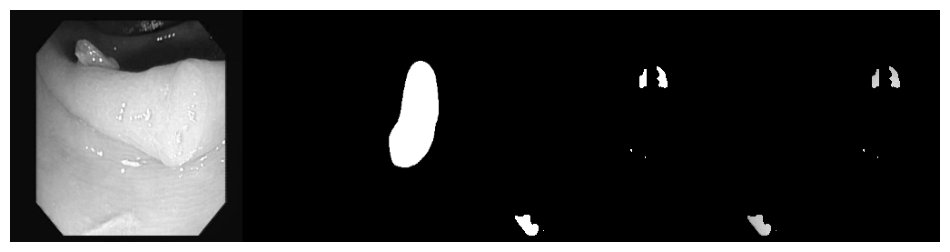

 Epoch: 84 of 100, Iter.: 31 of 31, Train Loss: -0.960443, IoU: 0.972844, Dice: 0.984233
 Epoch: 84 of 100, Iter.: 31 of 31, Valid Loss: -0.312407, IoU: 0.540140, Dice: 0.655573


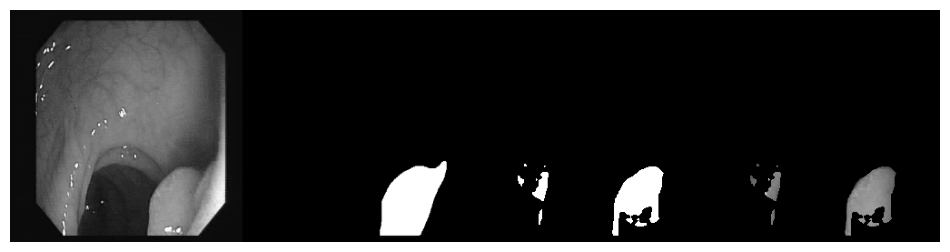

 Epoch: 85 of 100, Iter.: 31 of 31, Train Loss: -0.964220, IoU: 0.974563, Dice: 0.985051
 Epoch: 85 of 100, Iter.: 31 of 31, Valid Loss: -0.295729, IoU: 0.531282, Dice: 0.647686


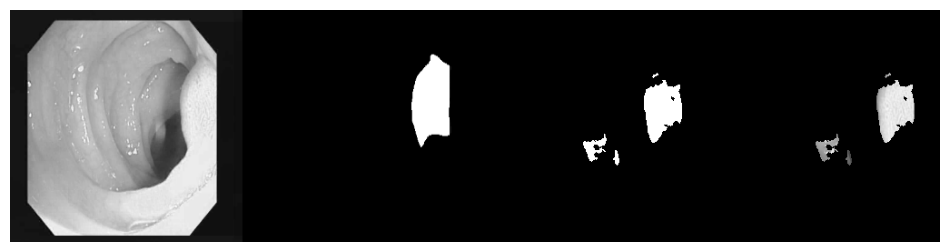

 Epoch: 86 of 100, Iter.: 31 of 31, Train Loss: -0.964268, IoU: 0.975036, Dice: 0.985459
 Epoch: 86 of 100, Iter.: 31 of 31, Valid Loss: -0.302744, IoU: 0.532689, Dice: 0.648808


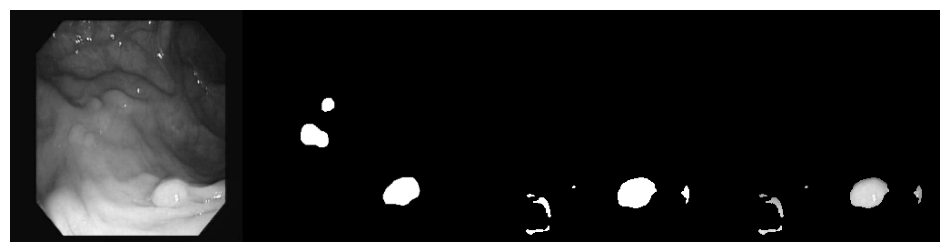

 Epoch: 87 of 100, Iter.: 31 of 31, Train Loss: -0.964943, IoU: 0.976086, Dice: 0.985979
 Epoch: 87 of 100, Iter.: 31 of 31, Valid Loss: -0.275997, IoU: 0.523185, Dice: 0.638187


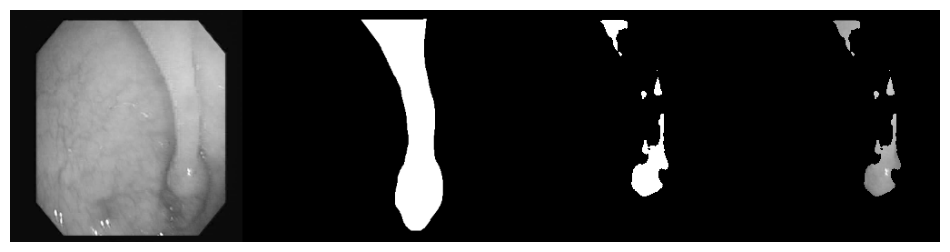

 Epoch: 88 of 100, Iter.: 31 of 31, Train Loss: -0.967888, IoU: 0.977925, Dice: 0.986983
 Epoch: 88 of 100, Iter.: 31 of 31, Valid Loss: -0.296379, IoU: 0.546217, Dice: 0.662394


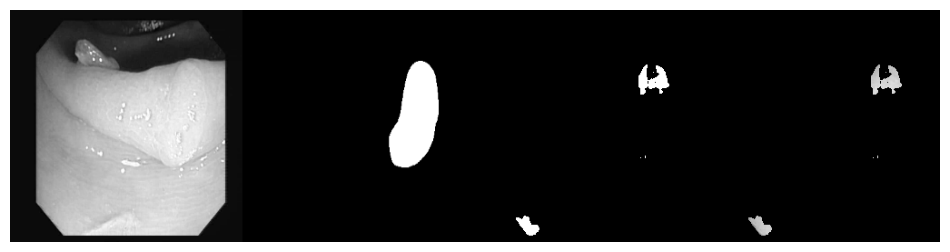

 Epoch: 89 of 100, Iter.: 31 of 31, Train Loss: -0.967534, IoU: 0.977646, Dice: 0.986848
 Epoch: 89 of 100, Iter.: 31 of 31, Valid Loss: -0.315460, IoU: 0.544837, Dice: 0.660042


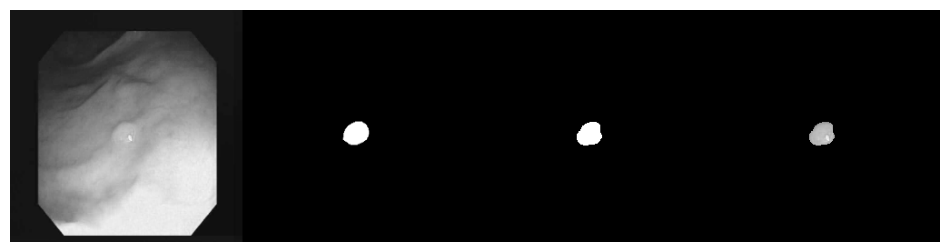

 Epoch: 90 of 100, Iter.: 31 of 31, Train Loss: -0.968598, IoU: 0.977678, Dice: 0.986887
 Epoch: 90 of 100, Iter.: 31 of 31, Valid Loss: -0.293905, IoU: 0.536730, Dice: 0.654295


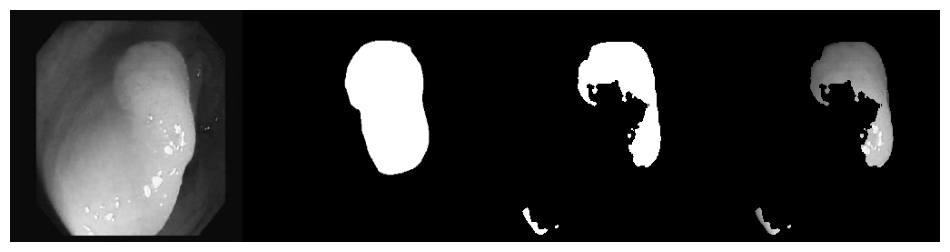

 Epoch: 91 of 100, Iter.: 31 of 31, Train Loss: -0.969718, IoU: 0.978555, Dice: 0.987361
 Epoch: 91 of 100, Iter.: 31 of 31, Valid Loss: -0.250368, IoU: 0.510453, Dice: 0.627761


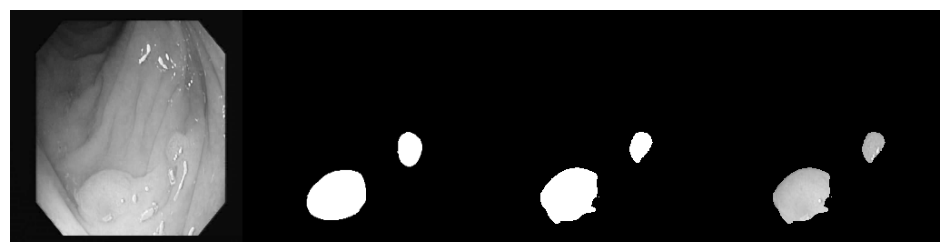

 Epoch: 92 of 100, Iter.: 31 of 31, Train Loss: -0.969879, IoU: 0.978587, Dice: 0.987378
 Epoch: 92 of 100, Iter.: 31 of 31, Valid Loss: -0.296125, IoU: 0.549718, Dice: 0.666925


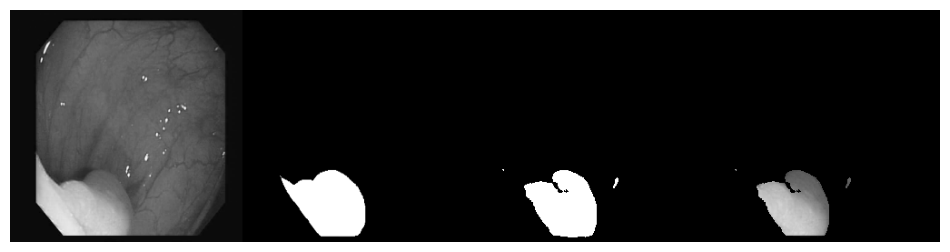

 Epoch: 93 of 100, Iter.: 31 of 31, Train Loss: -0.970472, IoU: 0.979038, Dice: 0.987689
 Epoch: 93 of 100, Iter.: 31 of 31, Valid Loss: -0.296174, IoU: 0.538283, Dice: 0.655233


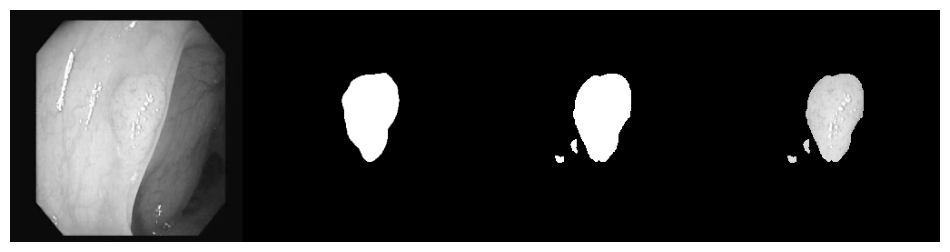

 Epoch: 94 of 100, Iter.: 31 of 31, Train Loss: -0.971547, IoU: 0.979827, Dice: 0.988120
 Epoch: 94 of 100, Iter.: 31 of 31, Valid Loss: -0.293866, IoU: 0.546222, Dice: 0.663347


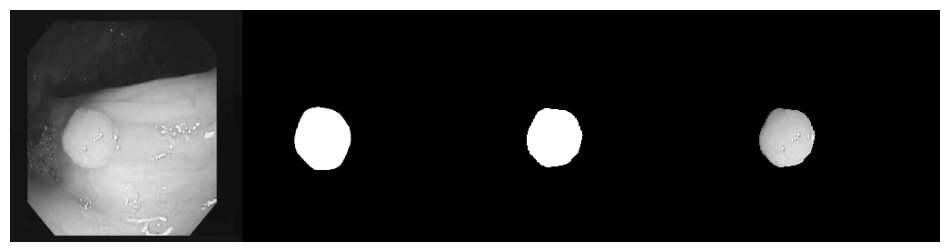

 Epoch: 95 of 100, Iter.: 31 of 31, Train Loss: -0.972800, IoU: 0.979946, Dice: 0.988154
 Epoch: 95 of 100, Iter.: 31 of 31, Valid Loss: -0.275704, IoU: 0.534814, Dice: 0.653197


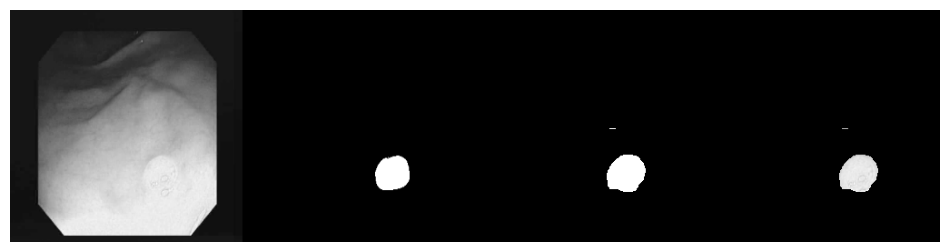

 Epoch: 96 of 100, Iter.: 31 of 31, Train Loss: -0.972473, IoU: 0.979834, Dice: 0.988211
 Epoch: 96 of 100, Iter.: 31 of 31, Valid Loss: -0.270568, IoU: 0.520502, Dice: 0.636390


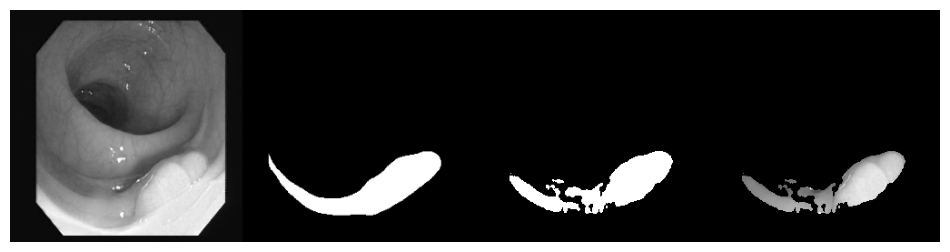

 Epoch: 97 of 100, Iter.: 31 of 31, Train Loss: -0.971153, IoU: 0.978816, Dice: 0.987658
 Epoch: 97 of 100, Iter.: 31 of 31, Valid Loss: -0.308514, IoU: 0.552387, Dice: 0.667580


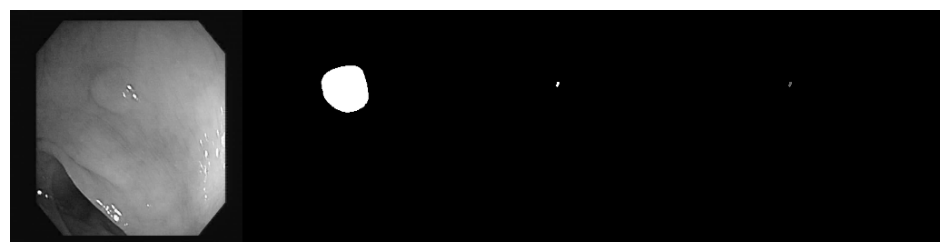

 Epoch: 98 of 100, Iter.: 31 of 31, Train Loss: -0.972563, IoU: 0.979271, Dice: 0.987843
 Epoch: 98 of 100, Iter.: 31 of 31, Valid Loss: -0.304688, IoU: 0.553573, Dice: 0.670137


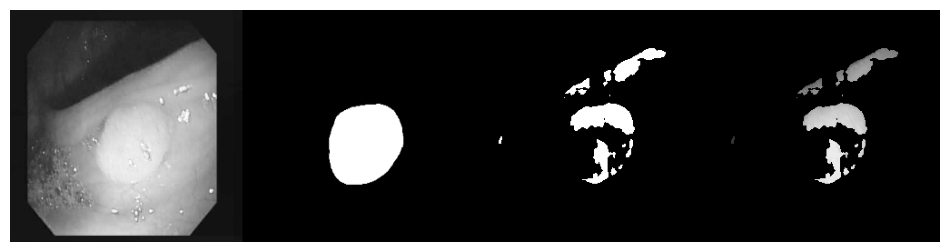

 Epoch: 99 of 100, Iter.: 31 of 31, Train Loss: -0.972532, IoU: 0.978896, Dice: 0.987220
 Epoch: 99 of 100, Iter.: 31 of 31, Valid Loss: -0.244012, IoU: 0.521082, Dice: 0.636485


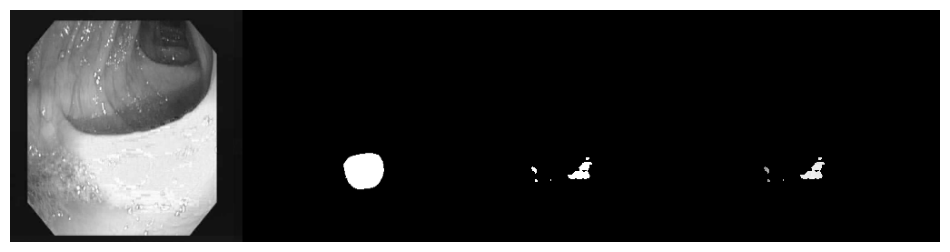

CPU times: user 11min 58s, sys: 12min 37s, total: 24min 35s
Wall time: 18min 26s


In [19]:

%%time
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test
from ploting import plot_model_prediction

data_name = 'ISIC'

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch = -1
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

for epoch in range(epochs):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 0:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    if epoch+1 % 10 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
        for i, (metric, value) in enumerate(metrics.items()):
            axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=3)
            axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=3)
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Loss')
            axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
            axs[i].legend(loc='best')
        plt.show()
    
    lst_epoch_metric.append([round(epoch_train_loss,2), round(epoch_val_loss,2), round(epoch_train_iou,2), 
                             round(epoch_val_iou,2), round(epoch_train_dice,2), round(epoch_val_dice,2)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_iou = epoch if best_iou == epoch_val_iou else best_epoch_iou
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
#     elif best_epoch + patience < epoch:
#         print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
#         break

# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'metric_{model_name}_{data_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_IOU:0.5854, Best_DiceScore:0.6971


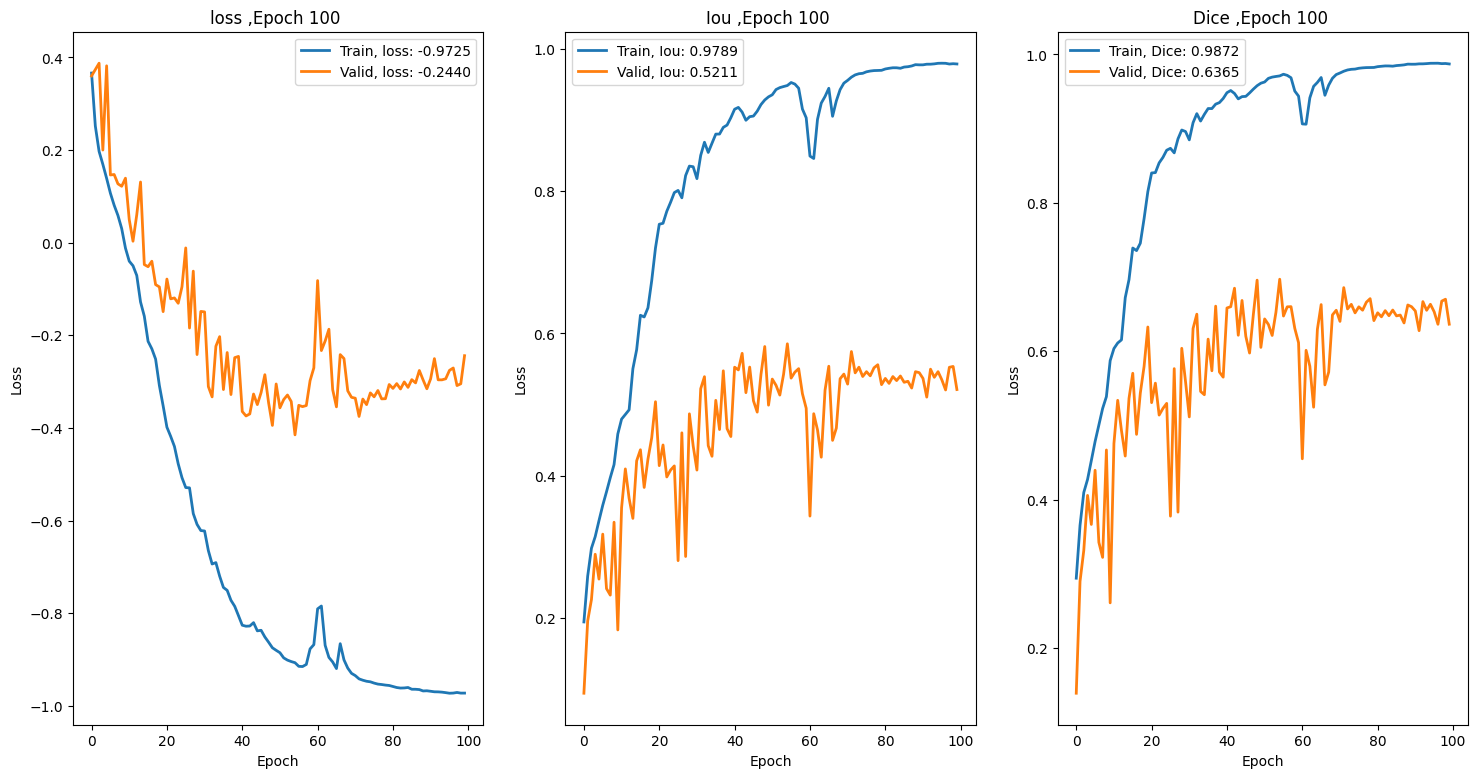

In [20]:
print(f'Validationset 기준 \nBest_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

# metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
#            'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
#            'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
    axs[i].legend(loc='best')
plt.show()